### 프로그래밍 환경 설정
 - 데이터 라이브러리 지정
 - 한글 관련 설정 등

In [30]:
## 사용자 정의 모듈 업데이트시마다 자동 load
%load_ext autoreload
%autoreload 2

### 공통 라이브러리 입수
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from IPython.display import display
# from IPython.display import set_matplotlib_formats
import os
import sys

### 시계열 예측 라이브러리
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

### 금융 / 경제 관련 라이브러리
import yfinance as yf
from fredapi import Fred

### 인터넷 접속 라이브러리 (한국은행,통계청)
import requests


# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# 출력 형식 설정
# set_matplotlib_formats('retina')

### 그래프 셋팅 (runtime configuration parameters (rcParams))
# plt.rcParams['font.family'] ='Malgun Gothic'  # 한글 깨짐 방지
# plt.rcParams['axes.unicode_minus'] = False    # 마이너스 부호 깨짐 방지
plt.style.use('ggplot')                       # 그래프 스타일

### 사용자 정의 모듈 import
import PM_Tool_Kit_2025 as pk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### API Keys (개인별)

In [31]:
fred_api = '37fdfb384dd480bdafee373103f17b7e'
bok_api = '8TJ1Y95C23DGOL7K2J1J'
kosis_api = 'NWI3OWJkODMwNzg3YjkwZDYyZGVjYzBkMWRiMjdmNTA='

### Yahoo finance
 - 금융시장 데이터 다운로드
 - tickers = ['MSFT','NVDA']
 - data = yf.download('tickers',start = '2000-01-01', end = '2024-12-31')
```
stock_price = yfinance.download(tickers, 
                                start=None, 
                                end=None, 
                                actions=False, 
                                threads=True, 
                                ignore_tz=None, 
                                group_by='column', 
                                auto_adjust=True, 
                                back_adjust=False, 
                                repair=False, 
                                keepna=False, 
                                progress=True, 
                                period='max', 
                                interval='1d', 
                                prepost=False,
                                proxy=None, 
                                rounding=False, 
                                timeout=10, 
                                session=None, 
                                multi_level_index=True)
```


In [32]:
### 티커 목록
stock_ticker = ['^KS11','^KQ11','^GSPC','^IXIC','^GDAXI','^N225','005930.KS']
rate_ticker = ['^FVX','^TNX','^TYX']
fx_ticker = ['USDKRW=X','JPY=X','EURUSD=X','GBPUSD=X','CNY=X']
raw_ticker = ['CL=F','GC=F','BTC-USD']

### 데이터 다운로드 기간
fin_from = '2018-01-01'

### 데이터 다운로드
df_stock = yf.download(stock_ticker, start = fin_from, auto_adjust=False, ignore_tz = True)    ## 주가지수
df_rate = yf.download(rate_ticker, start = fin_from, auto_adjust=False, ignore_tz = True)      ## 미국 금리
df_fx = yf.download(fx_ticker, start = fin_from, auto_adjust=False, ignore_tz = True)          ## 환율
df_raw = yf.download(raw_ticker, start = fin_from, auto_adjust=False, ignore_tz = True)        ## 원자재 및 비트코인

### 수정주가만 선택 & 인덱스 날짜 형식 정리
###    - strftime : string format time (시간을 문자열로)
###    - strptime : string parse time (문자열을 시간으로)
df_stock = df_stock['Adj Close']
df_stock.index = df_stock.index.date
df_rate = df_rate['Adj Close']
df_rate.index = df_rate.index.date
df_fx = df_fx['Adj Close']
df_fx.index = df_fx.index.date
df_raw = df_raw['Adj Close']
df_raw.index = df_raw.index.date


[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  3 of 3 completed


In [4]:
display(df_stock)

Ticker,005930.KS,^GDAXI,^GSPC,^IXIC,^KQ11,^KS11,^N225
2018-01-02,42469.519531,12871.389648,2695.810059,7006.899902,812.450012,2479.649902,NaN
2018-01-03,42968.976562,12978.209961,2713.060059,7065.529785,822.309998,2486.350098,NaN
2018-01-04,42519.468750,13167.889648,2723.989990,7077.910156,808.010010,2466.459961,23506.330078
2018-01-05,43385.179688,13319.639648,2743.149902,7136.560059,828.030029,2497.520020,23714.529297
2018-01-08,43301.937500,13367.780273,2747.709961,7157.390137,839.510010,2513.280029,NaN
...,...,...,...,...,...,...,...
2024-12-27,53700.000000,19984.320312,5970.839844,19722.029297,665.969971,2404.770020,40281.160156
2024-12-30,53200.000000,19909.140625,5906.939941,19486.789062,678.190002,2399.489990,39894.539062
2024-12-31,NaN,NaN,5881.629883,19310.789062,NaN,NaN,NaN
2025-01-02,53400.000000,20024.660156,5868.549805,19280.789062,686.630005,2398.939941,NaN


In [ ]:
### 야후 데이터 다운로드 실습








### Fred API (St.Louis FED)
- fred_data = fred.get_series(fred_ticker, observation_start='2010-01-01', observation_end='2025-12-31')
- 한번에 여러개의 데이터를 입수 가능한 Yahoo Finance와 달리 한번에 하나의 데이터만 입수 가능
- 데이터 티커 직관적이지 않아 이해가 어려움
- 한번에 여러개의 데이터를 입수하고, 데이터 티커를 내가 원하는 컬럼명으로 변경하는 함수 (multi_fred) 작성

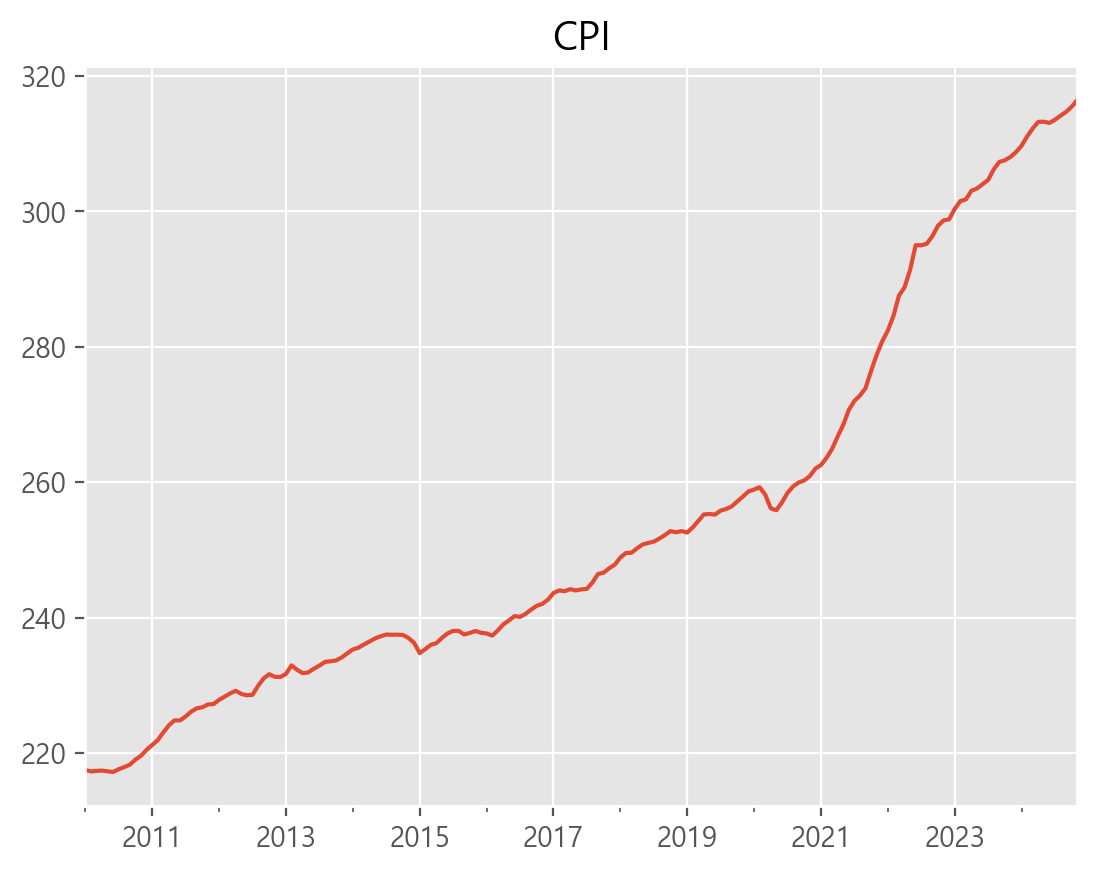

In [33]:
### FRED 데이터 입수 예제
fred = Fred(api_key = fred_api)
fred_data = fred.get_series('CPIAUCSL', observation_start='2010-01-01', observation_end='2025-12-31')
fred_data.plot(title = 'CPI');  ### <--- 세미콜론의 역할은?

Solarize_Light2


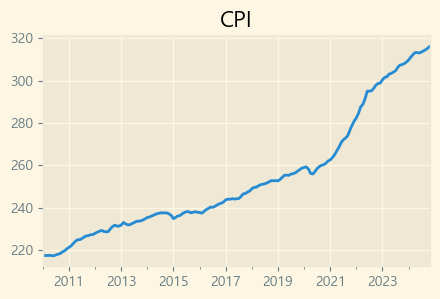

_classic_test_patch


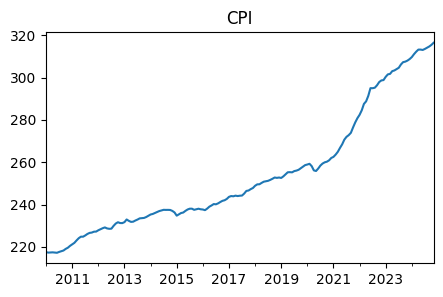

_mpl-gallery


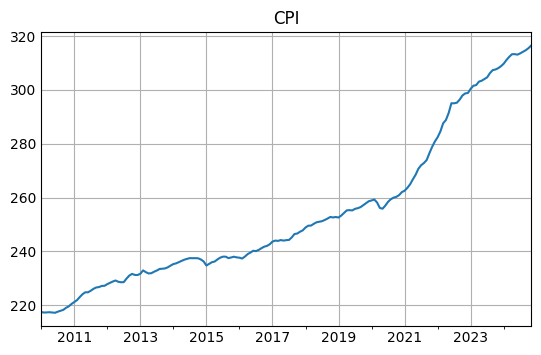

_mpl-gallery-nogrid


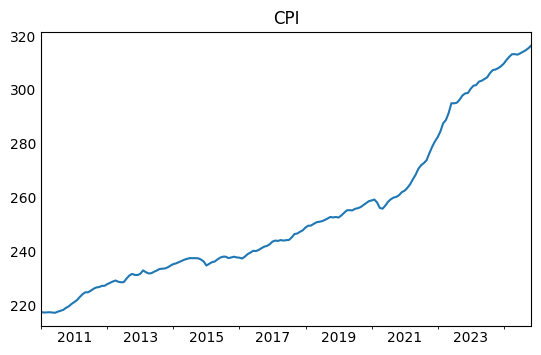

bmh


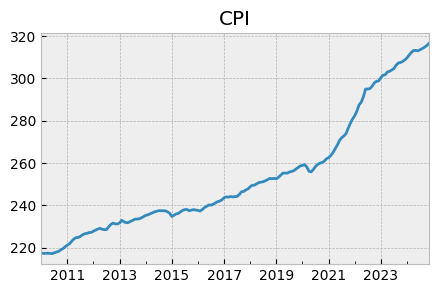

classic


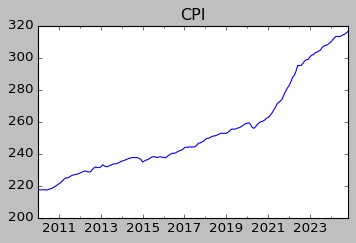

dark_background


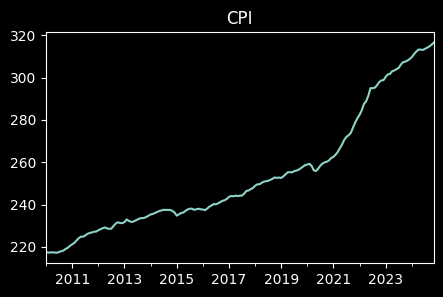

fast


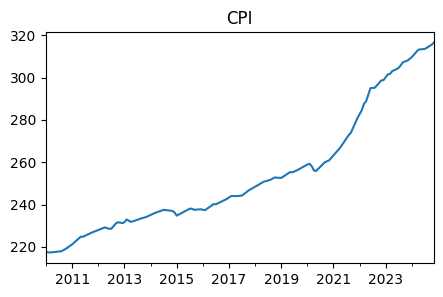

fivethirtyeight


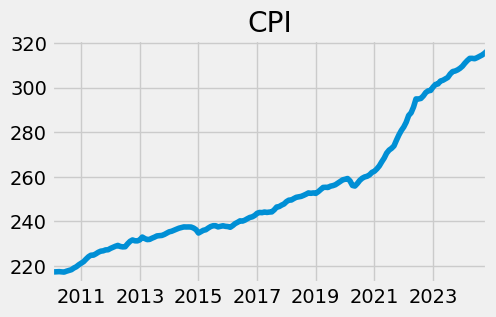

ggplot


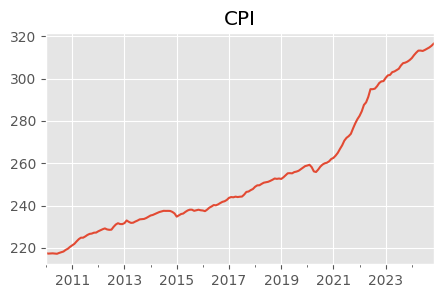

grayscale


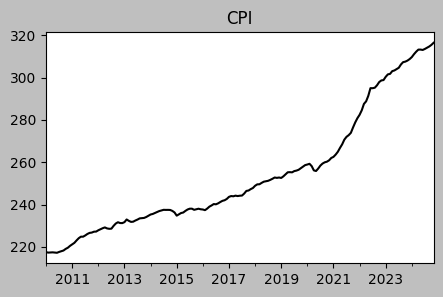

petroff10


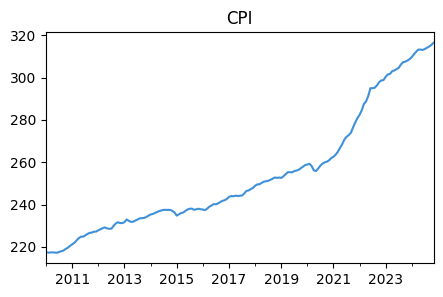

seaborn-v0_8


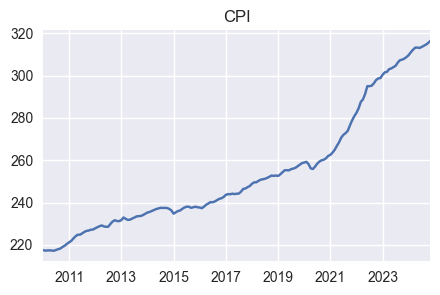

seaborn-v0_8-bright


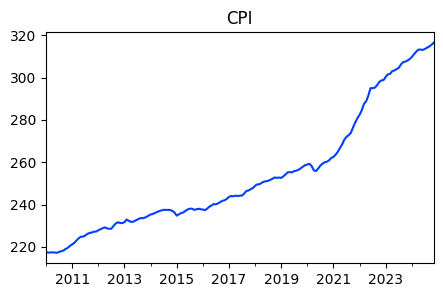

seaborn-v0_8-colorblind


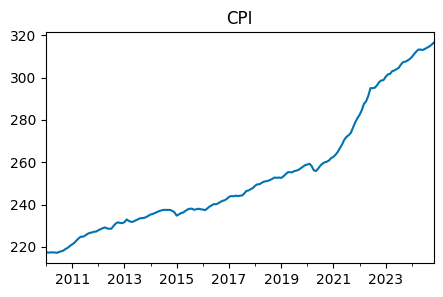

seaborn-v0_8-dark


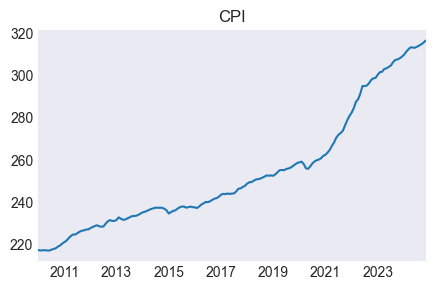

seaborn-v0_8-dark-palette


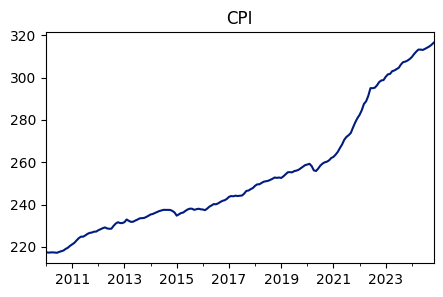

seaborn-v0_8-darkgrid


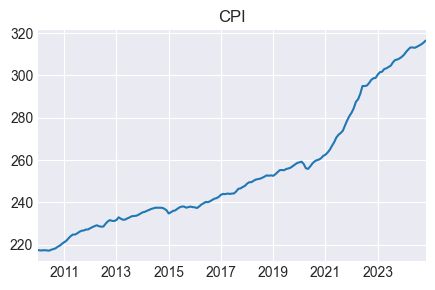

seaborn-v0_8-deep


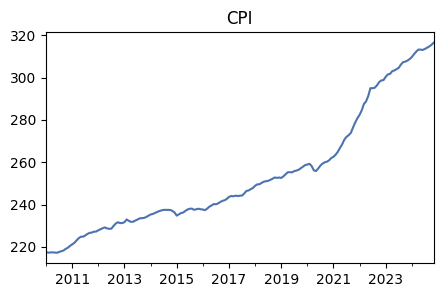

seaborn-v0_8-muted


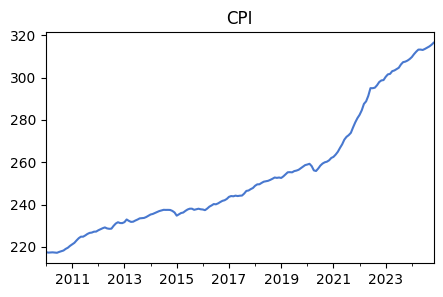

seaborn-v0_8-notebook


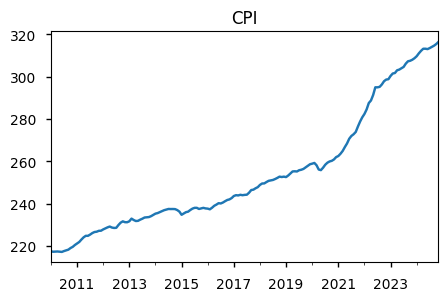

seaborn-v0_8-paper


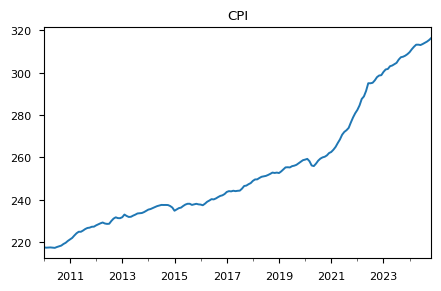

seaborn-v0_8-pastel


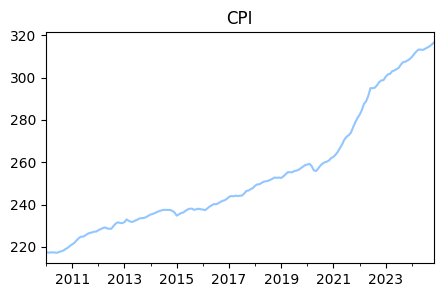

seaborn-v0_8-poster


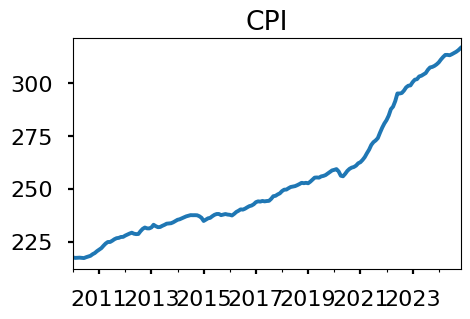

seaborn-v0_8-talk


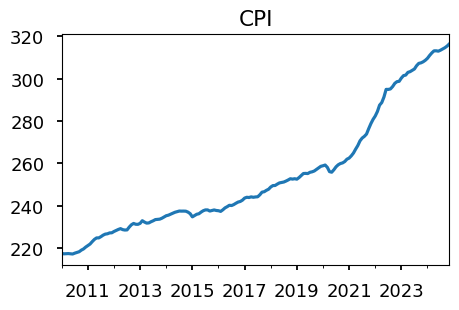

seaborn-v0_8-ticks


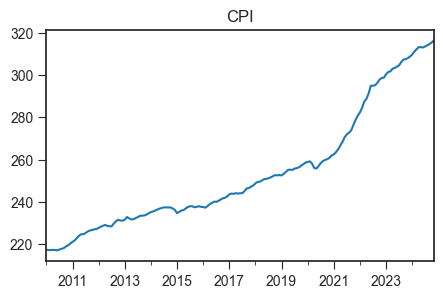

seaborn-v0_8-white


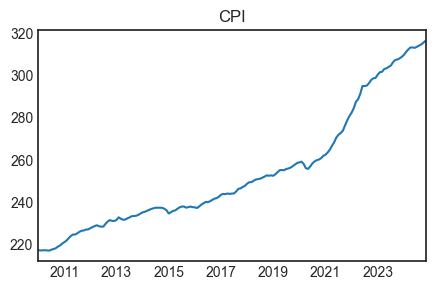

seaborn-v0_8-whitegrid


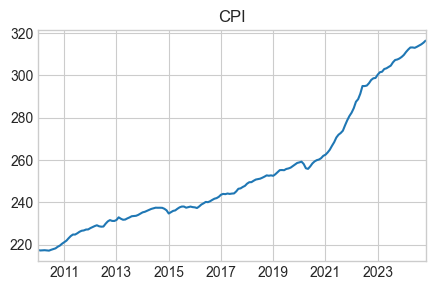

tableau-colorblind10


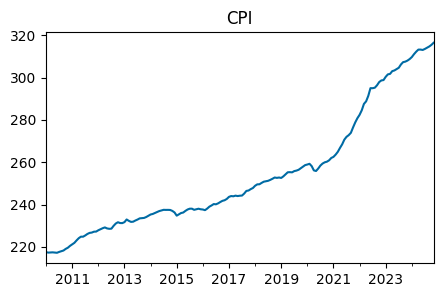

In [6]:
### <<참고>> matplotlib에서 제공하는 그래프스타일

# matplotlib에서 제공하는 스타일 목록 가져오기
styles = plt.style.available
for i in styles:
  plt.style.use(i)
  print (i)
  fred_data.plot(title = 'CPI',figsize = (5,3));  ### <--- 세미콜론의 역할은?
  plt.show()
  plt.rcdefaults()



### 한번에 여러개의 FRED데이터를 가져올 수 있는 함수 (multi_fred) 작성
- fred_data = multi_fred(ticker,observation_start,observation_end)

In [34]:
### 데이터 정의
### ['FRED Series Name','My alias'] --> 데이터프레임으로 
### Frequency가 동일한 데이터끼리 모을 것 (월별은 월별, 분기는 분기별...)

tickers = [['CPIAUCSL','CPI_SA'],
           ['CPIAUCNS','CPI_NSA'],
           ['CPILFESL','CORE_CPI_SA'],
           ['CPILFENS','CORE_CPI_NSA'],
           ['UNRATE','UNEMP_RATE'],
           ['PAYEMS','PAYEMS'],
           ['UNEMPLOY','UNEMPLOY'],
           ['JTSJOL','JOLT_JOB_OPEN'],
           ['RSXFS','RETAIL_SALES'],
           ['MARTSSM44W72USS','RETAIL_SALES_XAG']
           ]

df_tickers = pd.DataFrame(tickers,columns = ['fred','name'])

display(df_tickers)

,fred,name
0,CPIAUCSL,CPI_SA
1,CPIAUCNS,CPI_NSA
2,CPILFESL,CORE_CPI_SA
3,CPILFENS,CORE_CPI_NSA
4,UNRATE,UNEMP_RATE
5,PAYEMS,PAYEMS
6,UNEMPLOY,UNEMPLOY
7,JTSJOL,JOLT_JOB_OPEN
8,RSXFS,RETAIL_SALES
9,MARTSSM44W72USS,RETAIL_SALES_XAG


In [35]:
### 함수정의
### eco_ind_m = multi_fred(api_key,             : 등록된 api key
###                        ticker,              : ticker를 모은 데이터프레임
###                        observation_start,   : 데이터 입수 기간
###                        observation_end)

def multi_fred(api_key,ticker,observation_start,observation_end):

  # 라이브러리 정의
  fred = Fred(api_key = api_key)

  # 데이터 저장할 빈데이터프레임 정의
  fred_data = pd.DataFrame()

  # ticker 루프 실행
  for i,j in enumerate(ticker['fred']):

    # Fred 데이터 입수
    fred_data_ = fred.get_series(j, observation_start=observation_start, observation_end=observation_end)

    if i == 0 :
      fred_data = fred_data_

    if i > 0 :
      fred_data = pd.concat([fred_data,fred_data_],axis = 1)

  # 컬럼명 부여
  fred_data.columns = ticker['name']

  return fred_data

fred_data = multi_fred(fred_api,df_tickers,'2000-01-01','2025-12-31')

display(fred_data)

name,CPI_SA,CPI_NSA,CORE_CPI_SA,CORE_CPI_NSA,UNEMP_RATE,PAYEMS,UNEMPLOY,JOLT_JOB_OPEN,RETAIL_SALES,RETAIL_SALES_XAG
2000-01-01,169.300,168.800,179.300,178.800,4.0,131009.0,5708.0,NaN,243436.0,181007.0
2000-02-01,170.000,169.800,179.400,179.500,4.1,131120.0,5858.0,NaN,247133.0,182721.0
2000-03-01,171.000,171.200,180.000,180.500,4.0,131604.0,5733.0,NaN,249825.0,185940.0
2000-04-01,170.900,171.300,180.300,180.900,3.8,131883.0,5481.0,NaN,245831.0,185327.0
2000-05-01,171.200,171.500,180.700,180.900,4.0,132106.0,5758.0,NaN,246201.0,185371.0
...,...,...,...,...,...,...,...,...,...,...
2024-07-01,313.534,314.540,318.872,319.214,4.3,158692.0,7163.0,7711.0,615960.0,523859.0
2024-08-01,314.121,314.796,319.768,320.017,4.2,158770.0,7115.0,7861.0,614535.0,523935.0
2024-09-01,314.686,315.301,320.767,321.109,4.1,159025.0,6834.0,7372.0,620104.0,530276.0
2024-10-01,315.454,315.664,321.666,321.758,4.1,159061.0,6984.0,7744.0,622551.0,531115.0


In [36]:
### 데이터 산출 (전월비, 전년동월비 등)

fred_data['CPI_MoM'] = (fred_data['CPI_SA'] / fred_data['CPI_SA'].shift(1) -1) * 100
fred_data['CPI_YoY'] = (fred_data['CPI_NSA'] / fred_data['CPI_NSA'].shift(12) -1) * 100
fred_data['CORE_CPI_MoM'] = (fred_data['CORE_CPI_SA'] / fred_data['CORE_CPI_SA'].shift(1) -1) * 100
fred_data['CORE_CPI_YoY'] = (fred_data['CORE_CPI_NSA'] / fred_data['CORE_CPI_NSA'].shift(12) -1) * 100
fred_data['d_PAYEMS'] = fred_data['PAYEMS'] - fred_data['PAYEMS'].shift(1)
fred_data['RETAIL_MoM'] = (fred_data['RETAIL_SALES'] / fred_data['RETAIL_SALES'].shift(1)  - 1) * 100
fred_data['RETAIL_XAG_MoM'] = (fred_data['RETAIL_SALES_XAG'] / fred_data['RETAIL_SALES_XAG'].shift(12)  - 1) * 100

In [ ]:
### Fred 데이터 다운로드 및 함수작성 연습











### 통계청 데이터 입수 함수 (get_kosis)
 - 한번에 여러개의 통계청 데이터를 입수 할 수 있는 함수 작성
 - 하나의 티커로 시계열 지정할 수 있는 fred나 yahoo finance와 달리 각 시계열별로 통계표 명칭 및 세부 항목들을 지정해 줘야 하는 번거로움 있음 ㅠㅠ
 - 통계별 파라메터 : itmID,objL1~objL8,orgID,tblID
 - 공통 파라메터 : 조회기간, 주기



In [37]:
### 전체 지역별 아파트 가격 조회
### 통계청 홈페이지 > 국내통계 > 주제별통계 > 주거 > 전국주택가격동향(2021.06기준) > 유형별 매매가격지수

url = 'https://kosis.kr/openapi/Param/statisticsParameterData.do?method=getList&apiKey=' + kosis_api + '&' \
      'itmId=sales+&objL1=01+&objL2=a0+a7010103+a7010303+a7020201+a7020202+a7020203+a8010303+&objL3=&objL4=&objL5=&objL6=&objL7=&objL8=&format=json&jsonVD=Y&prdSe=M&startPrdDe=202405&endPrdDe=202411&orgId=408&tblId=DT_40803_N0001'
#https://kosis.kr/openapi/Param/statisticsParameterData.do?method=getList&apiKey=인증키없음&itmId=sales+&objL1=01+&objL2=a0+a7010103+a7010303+a7020201+a7020202+a7020203+a8010303+&objL3=&objL4=&objL5=&objL6=&objL7=&objL8=&format=json&jsonVD=Y&prdSe=M&startPrdDe=202405&endPrdDe=202411&orgId=408&tblId=DT_40803_N0001
response = requests.get(url)
data = response.json()
df = pd.DataFrame(data)
pd.options.display.max_columns = None
display(df)
pd.reset_option('display.max_columns')

,TBL_NM,PRD_DE,TBL_ID,ITM_NM,ITM_NM_ENG,ITM_ID,UNIT_NM,ORG_ID,UNIT_NM_ENG,C1_OBJ_NM,C1_OBJ_NM_ENG,C2_OBJ_NM,C2_OBJ_NM_ENG,DT,PRD_SE,C2,C1,C1_NM,C2_NM,C1_NM_ENG,C2_NM_ENG,LST_CHN_DE
0,유형별 매매가격지수,202405,DT_40803_N0001,매매가격,Sales Price Index,sales,2021.6 ＝ 100.0,408,2021.6 ＝ 100.0,주택유형별,Type,지역별,Region,92.78991873,M,a0,01,아파트,전국,Apartments,TheWholeCountry,2024-06-17
1,유형별 매매가격지수,202406,DT_40803_N0001,매매가격,Sales Price Index,sales,2021.6 ＝ 100.0,408,2021.6 ＝ 100.0,주택유형별,Type,지역별,Region,92.82579883,M,a0,01,아파트,전국,Apartments,TheWholeCountry,2024-07-15
2,유형별 매매가격지수,202407,DT_40803_N0001,매매가격,Sales Price Index,sales,2021.6 ＝ 100.0,408,2021.6 ＝ 100.0,주택유형별,Type,지역별,Region,93.01843439,M,a0,01,아파트,전국,Apartments,TheWholeCountry,2024-08-19
3,유형별 매매가격지수,202408,DT_40803_N0001,매매가격,Sales Price Index,sales,2021.6 ＝ 100.0,408,2021.6 ＝ 100.0,주택유형별,Type,지역별,Region,93.32211473,M,a0,01,아파트,전국,Apartments,TheWholeCountry,2024-09-20
4,유형별 매매가격지수,202409,DT_40803_N0001,매매가격,Sales Price Index,sales,2021.6 ＝ 100.0,408,2021.6 ＝ 100.0,주택유형별,Type,지역별,Region,93.53598059,M,a0,01,아파트,전국,Apartments,TheWholeCountry,2024-10-15
5,유형별 매매가격지수,202410,DT_40803_N0001,매매가격,Sales Price Index,sales,2021.6 ＝ 100.0,408,2021.6 ＝ 100.0,주택유형별,Type,지역별,Region,93.61288513,M,a0,01,아파트,전국,Apartments,TheWholeCountry,2024-11-21
6,유형별 매매가격지수,202411,DT_40803_N0001,매매가격,Sales Price Index,sales,2021.6 ＝ 100.0,408,2021.6 ＝ 100.0,주택유형별,Type,지역별,Region,93.61062166,M,a0,01,아파트,전국,Apartments,TheWholeCountry,2024-12-16
7,유형별 매매가격지수,202405,DT_40803_N0001,매매가격,Sales Price Index,sales,2021.6 ＝ 100.0,408,2021.6 ＝ 100.0,주택유형별,Type,지역별,Region,100.1537073,M,a7010103,01,아파트,용산,Apartments,Yongsan-gu,2024-06-17
8,유형별 매매가격지수,202406,DT_40803_N0001,매매가격,Sales Price Index,sales,2021.6 ＝ 100.0,408,2021.6 ＝ 100.0,주택유형별,Type,지역별,Region,101.0758041,M,a7010103,01,아파트,용산,Apartments,Yongsan-gu,2024-07-15
9,유형별 매매가격지수,202407,DT_40803_N0001,매매가격,Sales Price Index,sales,2021.6 ＝ 100.0,408,2021.6 ＝ 100.0,주택유형별,Type,지역별,Region,102.6319925,M,a7010103,01,아파트,용산,Apartments,Yongsan-gu,2024-08-19


In [38]:
df['DT'] = pd.to_numeric(df['DT'])
df_pivot = pd.pivot_table(data = df,index = ['PRD_DE'],columns = ['C1_NM','C2_NM'],values = 'DT')
df_pivot.index = pd.to_datetime(df_pivot.index,format = '%Y%m')
display(df_pivot)

C1_NM              아파트                                                  \
C2_NM               강남          마포          분당          서초          송파   
PRD_DE                                                                   
2024-05-01  101.762401   95.708241   96.191854  103.832461  100.372840   
2024-06-01  102.365921   96.498004   97.326817  104.930631  101.266072   
2024-07-01  103.836205   98.088802   98.692867  107.174186  103.695942   
2024-08-01  105.580130   99.723524  100.129136  109.897184  106.268463   
2024-09-01  106.950934  100.766147  101.313022  111.637606  107.587978   
2024-10-01  107.989319  101.477584  101.707268  112.491138  107.964443   
2024-11-01  108.737698  101.856516  101.746657  113.009165  108.182423   

C1_NM                              
C2_NM               용산         전국  
PRD_DE                             
2024-05-01  100.153707  92.789919  
2024-06-01  101.075804  92.825799  
2024-07-01  102.631992  93.018434  
2024-08-01  104.190191  93.322115  
2024-09-01  105.271073  93.535981  
2024-10-01  106.029443  93.612885  
2024-11-01  106.493595  93.610622

In [ ]:
### 통계청 데이터 조회 연습






In [39]:
### 조회 데이터 지정용 dataframe 작성

tables = [{'tbl_ID':'DT_40803_N0001','org_ID':'408','item_ID':'sales','obj_L1':'01+','obj_L2':'a0+a7+a7010103+a7010201+a7010303+a7020201+a7020202+a7020203'},
          {'tbl_ID':'DT_1J22003','org_ID':'101','item_ID':'T','obj_L1':'T10'},
          {'tbl_ID':'DT_1JH20202','org_ID':'101','item_ID':'T1','obj_L1':'1+1B+'}
          ]

df_tables = pd.DataFrame(tables,dtype = 'str')
df_tables.fillna('',inplace = True)
display(df_tables)

,tbl_ID,org_ID,item_ID,obj_L1,obj_L2
0,DT_40803_N0001,408,sales,01+,a0+a7+a7010103+a7010201+a7010303+a7020201+a702...
1,DT_1J22003,101,T,T10,
2,DT_1JH20202,101,T1,1+1B+,


In [44]:
### 함수작성 (get_kosis)
### 검색대상 시계열의 주기, 검색기간은 통일시킬 것

def get_kosis(api_key,tables,observation_start,observastion_end,freq):

  ### url 기록할 빈 리스트 정의
  urls = [""] * len(tables)

  ### url에 데이터 주기, 조회기간 추가
  prdSe = freq
  startPrdDe = observation_start
  endPrdDe = observastion_end

  url ="https://kosis.kr/openapi/Param/statisticsParameterData.do?method=getList&apiKey=" + api_key + "&" \
       "format=json&jsonVD=Y&prdSe=" + prdSe + "&startPrdDe=" + startPrdDe + "&endPrdDe=" + endPrdDe

  ### url에 org_id,table_id,item_id,기타 조회조건 추가
  for i in range(0,len(tables)):

    ### org_id,table_id,item_id 추가
    urls[i] = url  + "&orgId=" + tables.loc[i,'org_ID'] + "&tblId=" + tables.loc[i,'tbl_ID'] + "&itmId=" + tables.loc[i,'item_ID']

    ### 기타 조회조건 추가
    for j in tables.columns:
      if j == 'obj_L1':
        urls[i] = urls[i] + "&objL1=" + tables.loc[i,j]
      if j == 'obj_L2':
        urls[i] = urls[i] + "&objL2=" + tables.loc[i,j]
      if j == 'obj_L3':
        urls[i] = urls[i] + "&objL3=" + tables.loc[i,j]
      if j == 'obj_L4':
        urls[i] = urls[i] + "&objL4=" + tables.loc[i,j]

  ### 데이터 입수
  df_kosis = pd.DataFrame()  # 빈 데이터테이블 정의

  for i in range(0,len(tables)):

    ### 데이터 입수
    response = requests.get(urls[i])
    data = response.json()
    df = pd.DataFrame(data)
    df_kosis = pd.concat([df_kosis,df])

  ### 입수한 데이터를 날자 * 컬럼 형태로 피벗

  # 입수된 데이터는 문자열 형태이므로 숫자로 변환
  df_kosis['DT'] = pd.to_numeric(df_kosis['DT'])

  # 컬럼갯수가 가변적이므로 C1_NM~C8_NM 중에서 데이터프레임 내에 있는 컬럼만 추출
  # 컬럼명을 모두 _로 연결하여 피벗테이블의 컬럼명으로 함
  col_nm = ['C1_NM','C2_NM','C3_NM','C4_NM','C5_NM','C6_NM','C7_NM','C8_NM']
  sel_col_nm = df_kosis.columns[df_kosis.columns.isin(col_nm)]
  df_kosis['COL_NM'] = df_kosis['TBL_NM'] + '_'
  for i in sel_col_nm:
    df_kosis['COL_NM'] = df_kosis['COL_NM'] + df_kosis[i] + '_'
  df_kosis['COL_NM'] = df_kosis['COL_NM'].str[:-1]

  # 피벗 테이블 작성 및 인덱스를 datetime 형태로 변환
  df_kosis_pivot = pd.pivot_table(data = df_kosis,index = ['PRD_DE'],columns = ['COL_NM'],values = 'DT')
  df_kosis_pivot.index = pd.to_datetime(df_kosis_pivot.index,format = '%Y%m')

  return df_kosis_pivot

df_kosis = get_kosis(kosis_api,df_tables,"202301",'202412','M')
display(df_kosis)

COL_NM,유형별 매매가격지수_아파트_강남,유형별 매매가격지수_아파트_마포,유형별 매매가격지수_아파트_서울,유형별 매매가격지수_아파트_서초,유형별 매매가격지수_아파트_성동,유형별 매매가격지수_아파트_송파,유형별 매매가격지수_아파트_용산,유형별 매매가격지수_아파트_전국
PRD_DE,,,,,,,,
2023-01-01,99.880423,94.714957,94.622279,101.979661,96.495026,94.774744,98.511765,96.093247
2023-02-01,99.144424,93.718103,93.598845,101.481199,95.639924,94.285506,97.678134,94.540991
2023-03-01,98.717910,92.933730,92.926026,101.394476,94.865980,94.204049,96.977052,93.508776
2023-04-01,98.651119,92.604043,92.566592,101.419479,94.419468,94.248695,96.781954,92.925336
2023-05-01,99.094130,92.515962,92.577346,101.984202,94.401271,94.995600,96.924940,92.713998
2023-06-01,99.697243,92.797049,92.730810,102.512152,94.458696,96.118646,97.027254,92.675540
2023-07-01,100.162816,93.358348,92.979059,102.798758,94.873807,96.950818,97.327123,92.734964
2023-08-01,100.821393,94.080401,93.426975,103.177166,95.859420,98.244866,97.995706,92.951487
2023-09-01,101.449574,94.735711,93.891977,103.576752,96.579551,99.169001,98.683118,93.280281


In [14]:
### 사용자 정의 함수 파일로 이전후 확인
display(pk.get_kosis(kosis_api,df_tables,'202301','202412','M'))

COL_NM,유형별 매매가격지수_아파트_강남,유형별 매매가격지수_아파트_마포,유형별 매매가격지수_아파트_서울,유형별 매매가격지수_아파트_서초,유형별 매매가격지수_아파트_성동,유형별 매매가격지수_아파트_송파,유형별 매매가격지수_아파트_용산,유형별 매매가격지수_아파트_전국
PRD_DE,,,,,,,,
2023-01-01,99.880423,94.714957,94.622279,101.979661,96.495026,94.774744,98.511765,96.093247
2023-02-01,99.144424,93.718103,93.598845,101.481199,95.639924,94.285506,97.678134,94.540991
2023-03-01,98.717910,92.933730,92.926026,101.394476,94.865980,94.204049,96.977052,93.508776
2023-04-01,98.651119,92.604043,92.566592,101.419479,94.419468,94.248695,96.781954,92.925336
2023-05-01,99.094130,92.515962,92.577346,101.984202,94.401271,94.995600,96.924940,92.713998
2023-06-01,99.697243,92.797049,92.730810,102.512152,94.458696,96.118646,97.027254,92.675540
2023-07-01,100.162816,93.358348,92.979059,102.798758,94.873807,96.950818,97.327123,92.734964
2023-08-01,100.821393,94.080401,93.426975,103.177166,95.859420,98.244866,97.995706,92.951487
2023-09-01,101.449574,94.735711,93.891977,103.576752,96.579551,99.169001,98.683118,93.280281


In [ ]:
### 통계청 데이터 실습






### 한국은행 데이터 입수 함수 (get_bok)
 - 한번에 여러개의 한국은행 데이터를 입수 할 수 있는 함수 작성
 - 통계별 파라메터 : stat_code, item_code1~item_code4
 - 공통 파라메터 : 조회기간, 주기

In [46]:
### 데이터 입수 예제
### 통계표 코드 : 817Y002 (시장금리)
### 통계코드1  : 010200000 (국고채 3년)

url = 'https://ecos.bok.or.kr/api/StatisticSearch/' + bok_api + '/JSON/kr/1/10000/817Y002/D/19800101/20211231/010200000/?/?/?'
print(url)
response = requests.get(url)
data = response.json()
df = pd.DataFrame(data['StatisticSearch']['row'])
display(df)

https://ecos.bok.or.kr/api/StatisticSearch/8TJ1Y95C23DGOL7K2J1J/JSON/kr/1/10000/817Y002/D/19800101/20211231/010200000/?/?/?


,STAT_CODE,STAT_NAME,ITEM_CODE1,ITEM_NAME1,ITEM_CODE2,ITEM_NAME2,ITEM_CODE3,ITEM_NAME3,ITEM_CODE4,ITEM_NAME4,UNIT_NAME,WGT,TIME,DATA_VALUE
0,817Y002,1.3.2.1. 시장금리(일별),010200000,국고채(3년),None,None,None,None,None,None,연%,None,19981113,8.6
1,817Y002,1.3.2.1. 시장금리(일별),010200000,국고채(3년),None,None,None,None,None,None,연%,None,19981116,8.5
2,817Y002,1.3.2.1. 시장금리(일별),010200000,국고채(3년),None,None,None,None,None,None,연%,None,19981117,8.45
3,817Y002,1.3.2.1. 시장금리(일별),010200000,국고채(3년),None,None,None,None,None,None,연%,None,19981118,8.45
4,817Y002,1.3.2.1. 시장금리(일별),010200000,국고채(3년),None,None,None,None,None,None,연%,None,19981119,8.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5740,817Y002,1.3.2.1. 시장금리(일별),010200000,국고채(3년),None,None,None,None,None,None,연%,None,20211227,1.776
5741,817Y002,1.3.2.1. 시장금리(일별),010200000,국고채(3년),None,None,None,None,None,None,연%,None,20211228,1.786
5742,817Y002,1.3.2.1. 시장금리(일별),010200000,국고채(3년),None,None,None,None,None,None,연%,None,20211229,1.783
5743,817Y002,1.3.2.1. 시장금리(일별),010200000,국고채(3년),None,None,None,None,None,None,연%,None,20211230,1.799


In [ ]:
### 한국은행 데이터 다운로드 실습







In [47]:
### 여러개의 한국은행 데이터를 한번에 입수하기 위한 데이터 프레임 
### ['Series Alias','stat_code','item_code1','item_code2','item_code3','item_code4']
### 데이터 주기는 일치시킬 것

rates_d = [
    ['CD91','817Y002','010502000','','',''],
    ['KTB3Y','817Y002','010200000','','',''],
    ['KTB5Y','817Y002','010200001','','',''],
    ['KTB10Y','817Y002','010210000','','','']
    ]


indprod_m = [
    ['INDPROD_ELEC_PROD','901Y032','I11ACQ','2','',''],
    ['INDPROD_ELEC_SHIP','901Y032','I11ACQ','4','',''],
    ['INDPROD_ELEC_INV','901Y032','I11ACQ','6','',''],
    ['INDPROD_CAR_PROD','901Y032','I11ACU','2','',''],
    ['INDPROD_CAR_SHIP','901Y032','I11ACU','4','',''],
    ['INDPROD_CAR_INV','901Y032','I11ACU','6','',''],
          ]


df_tables_d = pd.DataFrame(rates_d,columns = ['sr_name','table_cd','item_code_1','item_code_2','item_code_3','item_code_4'],dtype = 'str')
df_tables_m = pd.DataFrame(indprod_m,columns = ['sr_name','table_cd','item_code_1','item_code_2','item_code_3','item_code_4'],dtype = 'str')
display(df_tables_d)
display(df_tables_m)


,sr_name,table_cd,item_code_1,item_code_2,item_code_3,item_code_4
0,CD91,817Y002,010502000,,,
1,KTB3Y,817Y002,010200000,,,
2,KTB5Y,817Y002,010200001,,,
3,KTB10Y,817Y002,010210000,,,


,sr_name,table_cd,item_code_1,item_code_2,item_code_3,item_code_4
0,INDPROD_ELEC_PROD,901Y032,I11ACQ,2,,
1,INDPROD_ELEC_SHIP,901Y032,I11ACQ,4,,
2,INDPROD_ELEC_INV,901Y032,I11ACQ,6,,
3,INDPROD_CAR_PROD,901Y032,I11ACU,2,,
4,INDPROD_CAR_SHIP,901Y032,I11ACU,4,,
5,INDPROD_CAR_INV,901Y032,I11ACU,6,,


In [48]:
### 한국은행 데이터 다운로드 함수 작성
### 통계별 입력항목 : 통계표 코드 + 통계항목코드 1~4
### 일별, 월별 데이터 지원

data = df_tables_m
freq = 'M'
data_from = '202301'
data_to = '202412'

api_key = bok_api

def get_bok(api_key,data,freq,data_from,data_to):

  bok_out = pd.DataFrame()

  if freq == 'D':
    date_format = '%Y%m%d'
  if freq == 'M':
    date_format = '%Y%m'


  for i in range(0,len(data)):

    table_cd = data.loc[i,'table_cd']

    item_code_2 = '?'
    item_code_3 = '?'
    item_code_4 = '?'

    item_code_1 = data.loc[i,'item_code_1']
    item_code_2 = data.loc[i,'item_code_2']
    item_code_3 = data.loc[i,'item_code_3']
    item_code_4 = data.loc[i,'item_code_4']

    url = 'https://ecos.bok.or.kr/api/StatisticSearch/' + api_key + \
          '/JSON/kr/1/10000/'+table_cd+'/'+freq+'/' + data_from + '/' + data_to + '/' +\
          item_code_1+'/'+item_code_2+'/'+item_code_3+'/'+item_code_4

    response = requests.get(url)
    bok_data = response.json()
    df = pd.DataFrame(bok_data['StatisticSearch']['row'])
    df['SR_NAME'] = data.loc[i,'sr_name']
    bok_out = pd.concat([bok_out,df])

  bok_out['DATA_VALUE'] = pd.to_numeric(bok_out['DATA_VALUE'])
  bok_out['TIME'] = pd.to_datetime(bok_out['TIME'],format=date_format)
  bok_out_pivot = pd.pivot_table(data = bok_out,index = ['TIME'],columns = ['SR_NAME'],values = 'DATA_VALUE',aggfunc = 'mean')

  return bok_out_pivot

bok_out = get_bok(bok_api,df_tables_m,'M','202301','202412')
bok_out_pk = pk.get_bok(bok_api,df_tables_m,'M','202301','202412')

display(bok_out)
display(bok_out_pk)


SR_NAME,INDPROD_CAR_INV,INDPROD_CAR_PROD,INDPROD_CAR_SHIP,INDPROD_ELEC_INV,INDPROD_ELEC_PROD,INDPROD_ELEC_SHIP
TIME,,,,,,
2023-01-01,112.0,126.8,123.6,155.7,98.2,86.2
2023-02-01,113.8,124.4,124.1,158.9,89.7,82.2
2023-03-01,113.5,129.6,126.2,157.7,104.3,105.9
2023-04-01,114.2,128.5,124.8,183.1,106.3,90.6
2023-05-01,112.3,136.2,133.1,185.6,110.5,100.6
2023-06-01,110.2,127.4,127.4,163.4,110.2,129.3
2023-07-01,112.6,125.7,124.8,170.2,105.9,99.3
2023-08-01,115.3,133.7,130.7,189.7,120.6,106.9
2023-09-01,116.8,125.8,122.5,183.2,132.4,131.5


SR_NAME,INDPROD_CAR_INV,INDPROD_CAR_PROD,INDPROD_CAR_SHIP,INDPROD_ELEC_INV,INDPROD_ELEC_PROD,INDPROD_ELEC_SHIP
TIME,,,,,,
2023-01-01,112.0,126.8,123.6,155.7,98.2,86.2
2023-02-01,113.8,124.4,124.1,158.9,89.7,82.2
2023-03-01,113.5,129.6,126.2,157.7,104.3,105.9
2023-04-01,114.2,128.5,124.8,183.1,106.3,90.6
2023-05-01,112.3,136.2,133.1,185.6,110.5,100.6
2023-06-01,110.2,127.4,127.4,163.4,110.2,129.3
2023-07-01,112.6,125.7,124.8,170.2,105.9,99.3
2023-08-01,115.3,133.7,130.7,189.7,120.6,106.9
2023-09-01,116.8,125.8,122.5,183.2,132.4,131.5


In [ ]:
### 한국은행 데이터 다운로드 함수 작성 실습








### 시계열 예측 연습

C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was ren

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=541.427, Time=0.62 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=622.184, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=618.421, Time=0.08 sec


C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=594.528, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=620.184, Time=0.05 sec


C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=539.716, Time=0.32 sec


C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=539.598, Time=0.27 sec


C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=539.329, Time=0.47 sec


C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=540.643, Time=0.57 sec


C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=540.661, Time=0.35 sec


C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=542.556, Time=0.72 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=537.958, Time=0.11 sec


C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,2)(0,0,0)[0]             : AIC=537.995, Time=0.09 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=539.223, Time=0.29 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=539.185, Time=0.16 sec


C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,2)(0,0,0)[0]             : AIC=538.337, Time=0.16 sec


C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,4)(0,0,0)[0]             : AIC=541.094, Time=0.36 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 5.029 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  287
Model:               SARIMAX(0, 2, 3)   Log Likelihood                -264.979
Date:                Sun, 05 Jan 2025   AIC                            537.958
Time:                        02:49:21   BIC                            552.568
Sample:                    01-01-2000   HQIC                           543.815
                         - 11-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3975      0.038    -10.574      0.000      -0.471  

C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\youid\anaconda3\envs\py_port_mgmt\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


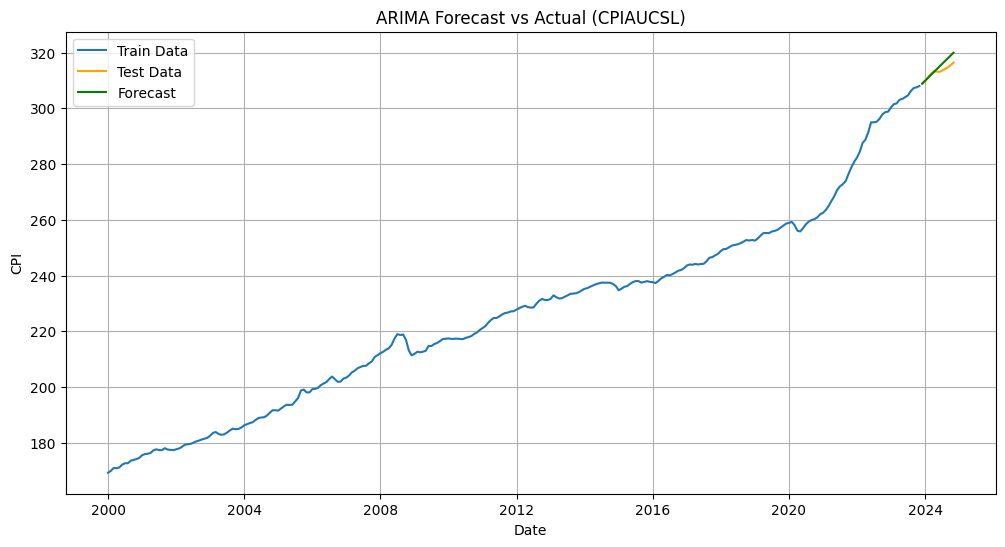

In [18]:
# 시계열 예측 함수 정의
def arima_forecast(data, train_period=-12):
    """
    ARIMA 기반 시계열 예측 프로그램
    Args:
        data (pd.Series): 시계열 데이터 (인덱스는 날짜, 값은 데이터)
        train_period: 전체데이터에서 -n개 만큼을 제외하고 트레이닝 데이터로 활용 (n개는 테스트 데이터)
    Returns:
        None
    """
    # 데이터 분할
    train_data = data[:train_period]
    test_data = data[train_period:]

    # ARIMA 모델 자동 선택 (p, d, q)
    model = auto_arima(
        train_data,
        seasonal=False,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    # 모델 요약 출력
    print(model.summary())

    # 모델 훈련
    model.fit(train_data)

    # 예측 수행
    forecast = model.predict(n_periods=len(test_data))

    # 예측결과를 데이터프레임에 저장
    df_forecast = pd.DataFrame(forecast,columns = [train_data.name])

    # 훈련데이터와 예측결과를 결합
    df_out = pd.concat([train_data,df_forecast],axis =0)

    # 결과값
    #result = data
    result = pd.concat([train_data,df_forecast],axis =0)


    # RMSE% 계산
    rmse = np.sqrt(mean_squared_error(test_data, forecast))
    rmse_percentage = (rmse / np.mean(test_data)) * 100

    print(f"Out of Sample RMSE: {rmse}")
    print(f"Out of Sample RMSE Percentage: {rmse_percentage:.2f}%")

    # 결과 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(train_data, label='Train Data')
    plt.plot(test_data, label='Test Data', color='orange')
    plt.plot(test_data.index, forecast, label='Forecast', color='green')
    plt.legend(loc='upper left')
    plt.title("ARIMA Forecast vs Actual (CPIAUCSL)")
    plt.xlabel('Date')
    plt.ylabel('CPI')
    plt.grid(True)
    plt.show()

    return df_out

# ARIMA 예측 실행
cpi = fred_data['CPI_SA']
cpi_fore = arima_forecast(cpi)

In [ ]:
### 시계열 예측 실습





### Dashboard 작성

In [49]:
### 한국은행 데이터
### 시장금리, 월간 (CPI, BSI, 수출, 수입, 산업생산)

rates_d_cd = [
    ['CD91','817Y002','010502000','','',''],
    ['KTB3Y','817Y002','010200000','','',''],
    ['KTB5Y','817Y002','010200001','','',''],
    ['KTB10Y','817Y002','010210000','','','']
    ]

df_rates_d_cd = pd.DataFrame(rates_d_cd,columns = ['sr_name','table_cd','item_code_1','item_code_2','item_code_3','item_code_4'],dtype = 'str')

macro_m_cd = [
    ['KOR_CPI','901Y009','0','','',''],   # 소비자 물가 (총지수)
    ['KOR_CPI_CORE','901Y010','DB','','',''],  # 소비자 물가 (식료품 및 에너지 제외)
    ['KOR_BSI','512Y007','AA','99988','',''],  # 한국은행 BSI (업종별 기업경기실사지수, 실적, 업황실적 BSI, 전산업)
    ['KOR_EXPORT','901Y011','FIEE','','',''],  # 국별수출(관세청, 천달러)
    ['KOR_IMPORT','901Y012','FIEF','','',''],  # 국별수입(관세청, 천달러)
    ['KOR_IP_PROD','901Y032','I11A','2','',''],  # 산업별 생산/출하/재고 (전산업, 생산지수, 계절조정)
    ['KOR_IP_SHIP','901Y032','I11A','4','',''],  # 산업별 생산/출하/재고 (전산업, 출하지수, 계절조정)
    ['KOR_IP_INV','901Y032','I11A','6','',''],  # 산업별 생산/출하/재고 (전산업, 재고지수, 계절조정)
    ['KOR_IP_ELEC_PROD','901Y032','I11ACQ','2','',''],  # 산업별 생산/출하/재고 (전자부품,컴퓨터,영상음향 및 통신장비, 생산지수, 계절조정)
    ['KOR_IP_ELEC_SHIP','901Y032','I11ACQ','4','',''],  # 산업별 생산/출하/재고 (전자부품,컴퓨터,영상음향 및 통신장비, 출하지수, 계절조정)
    ['KOR_IP_ELEC_INV','901Y032','I11ACQ','6','',''],  # 산업별 생산/출하/재고 (전자부품,컴퓨터,영상음향 및 통신장비, 재고지수, 계절조정)
    ['KOR_IP_CAR_PROD','901Y032','I11ACU','2','',''],  # 산업별 생산/출하/재고 (자동차 및 트레일러, 생산지수, 계절조정)
    ['KOR_IP_CAR_SHIP','901Y032','I11ACU','4','',''],  # 산업별 생산/출하/재고 (자동차 및 트레일러, 출하지수, 계절조정)
    ['KOR_IP_CAR_INV','901Y032','I11ACU','6','','']  # 산업별 생산/출하/재고 (자동차 및 트레일러, 재고지수, 계절조정)
    ]

df_macro_m_cd = pd.DataFrame(macro_m_cd,columns = ['sr_name','table_cd','item_code_1','item_code_2','item_code_3','item_code_4'],dtype = 'str')

df_rates_d = pk.get_bok(bok_api,df_rates_d_cd,'D','20180101','20241231')
df_macro_m = pk.get_bok(bok_api,df_macro_m_cd,'M','201801','202412')

d_kor_cpi = (df_macro_m['KOR_CPI'] / df_macro_m['KOR_CPI'].shift(12) - 1) * 100
d_kor_cpi_core = (df_macro_m['KOR_CPI_CORE'] / df_macro_m['KOR_CPI_CORE'].shift(12) - 1) * 100


In [50]:
d_kor_cpi = (df_macro_m['KOR_CPI'] / df_macro_m['KOR_CPI'].shift(12) - 1) * 100
d_kor_cpi_core = (df_macro_m['KOR_CPI_CORE'] / df_macro_m['KOR_CPI_CORE'].shift(12) - 1) * 100


In [51]:
### 통계청 데이터 입수

tables = [{'tbl_ID':'DT_40803_N0001','org_ID':'408','item_ID':'sales','obj_L1':'01+','obj_L2':'a0+a7+a7010103+a7010201+a7010303+a7020201+a7020202+a7020203'}
          ]

df_tables = pd.DataFrame(tables,dtype = 'str')
df_tables.fillna('',inplace = True)

apt_pr = pk.get_kosis(kosis_api,df_tables,'201001','202412','M')


In [22]:
display(apt_pr)

COL_NM,유형별 매매가격지수_아파트_강남,유형별 매매가격지수_아파트_마포,유형별 매매가격지수_아파트_서울,유형별 매매가격지수_아파트_서초,유형별 매매가격지수_아파트_성동,유형별 매매가격지수_아파트_송파,유형별 매매가격지수_아파트_용산,유형별 매매가격지수_아파트_전국
PRD_DE,,,,,,,,
2010-01-01,78.387322,74.902579,81.252124,77.474421,79.113468,76.873652,89.290108,73.617639
2010-02-01,78.664824,74.964684,81.461431,78.309547,79.218747,77.255652,89.359719,73.878790
2010-03-01,78.711689,75.066973,81.448211,78.406975,79.222246,77.373457,89.467594,74.071531
2010-04-01,78.663752,74.979455,81.366043,78.351919,79.201585,77.314473,89.550017,74.205051
2010-05-01,78.044777,74.738090,80.998179,78.067536,78.944321,76.988396,89.465171,74.214544
...,...,...,...,...,...,...,...,...
2024-07-01,103.836205,98.088802,95.889609,107.174186,101.873244,103.695942,102.631992,93.018434
2024-08-01,105.580130,99.723524,97.110856,109.897184,104.512005,106.268463,104.190191,93.322115
2024-09-01,106.950934,100.766147,97.882816,111.637606,105.732174,107.587978,105.271073,93.535981


### 대시보드 작성
 - 작성한 데이터셋을 주제별로 정리하여 사용자가 지정한 순서대로 출력
 - 주제, 차트제목, 데이터프레임명, 컬럼명 순
 - 시리즈일 경우 컬럼명을 ''로 지정


In [52]:
def dashboard(df_gr_out):

  row_per_page = 3
  col_per_page = 4
  cat_list = df_gr_out['cat'].unique()

  for i in range(0,len(cat_list)):

    df_gr_out_cat = df_gr_out[df_gr_out['cat'] == cat_list[i]]

    fig,ax = plt.subplots(row_per_page,col_per_page,figsize = (11.7,8.3))

    for j in range(0,row_per_page * col_per_page):

      if j < len(df_gr_out_cat):

        df_name = df_gr_out_cat.iloc[j]['df']
        df_col = df_gr_out_cat.iloc[j]['ticker']

        if df_col == '':
          sr = eval(df_name)
        else:
          df = eval(df_name)
          sr = df[df_col]

        y_i = j // col_per_page     # 몫
        x_i = j % col_per_page      # 나머지
        ax[y_i,x_i].plot(sr,label = df_gr_out_cat.iloc[j]['name'])
        ax[y_i,x_i].set_title(df_gr_out_cat.iloc[j]['name'],fontsize = 10)
        ax[y_i,x_i].tick_params(axis='x', labelsize=8)
        ax[y_i,x_i].tick_params(axis='y', labelsize=8)

      if j >= len(df_gr_out_cat):

        y_i = j // col_per_page     # 몫
        x_i = j % col_per_page      # 나머지
        ax[y_i,x_i].axis('off')


    plt.suptitle(cat_list[i],fontsize = 18)
    plt.tight_layout()
    # plt.savefig(cat_list[i] + '.png')
    plt.show()



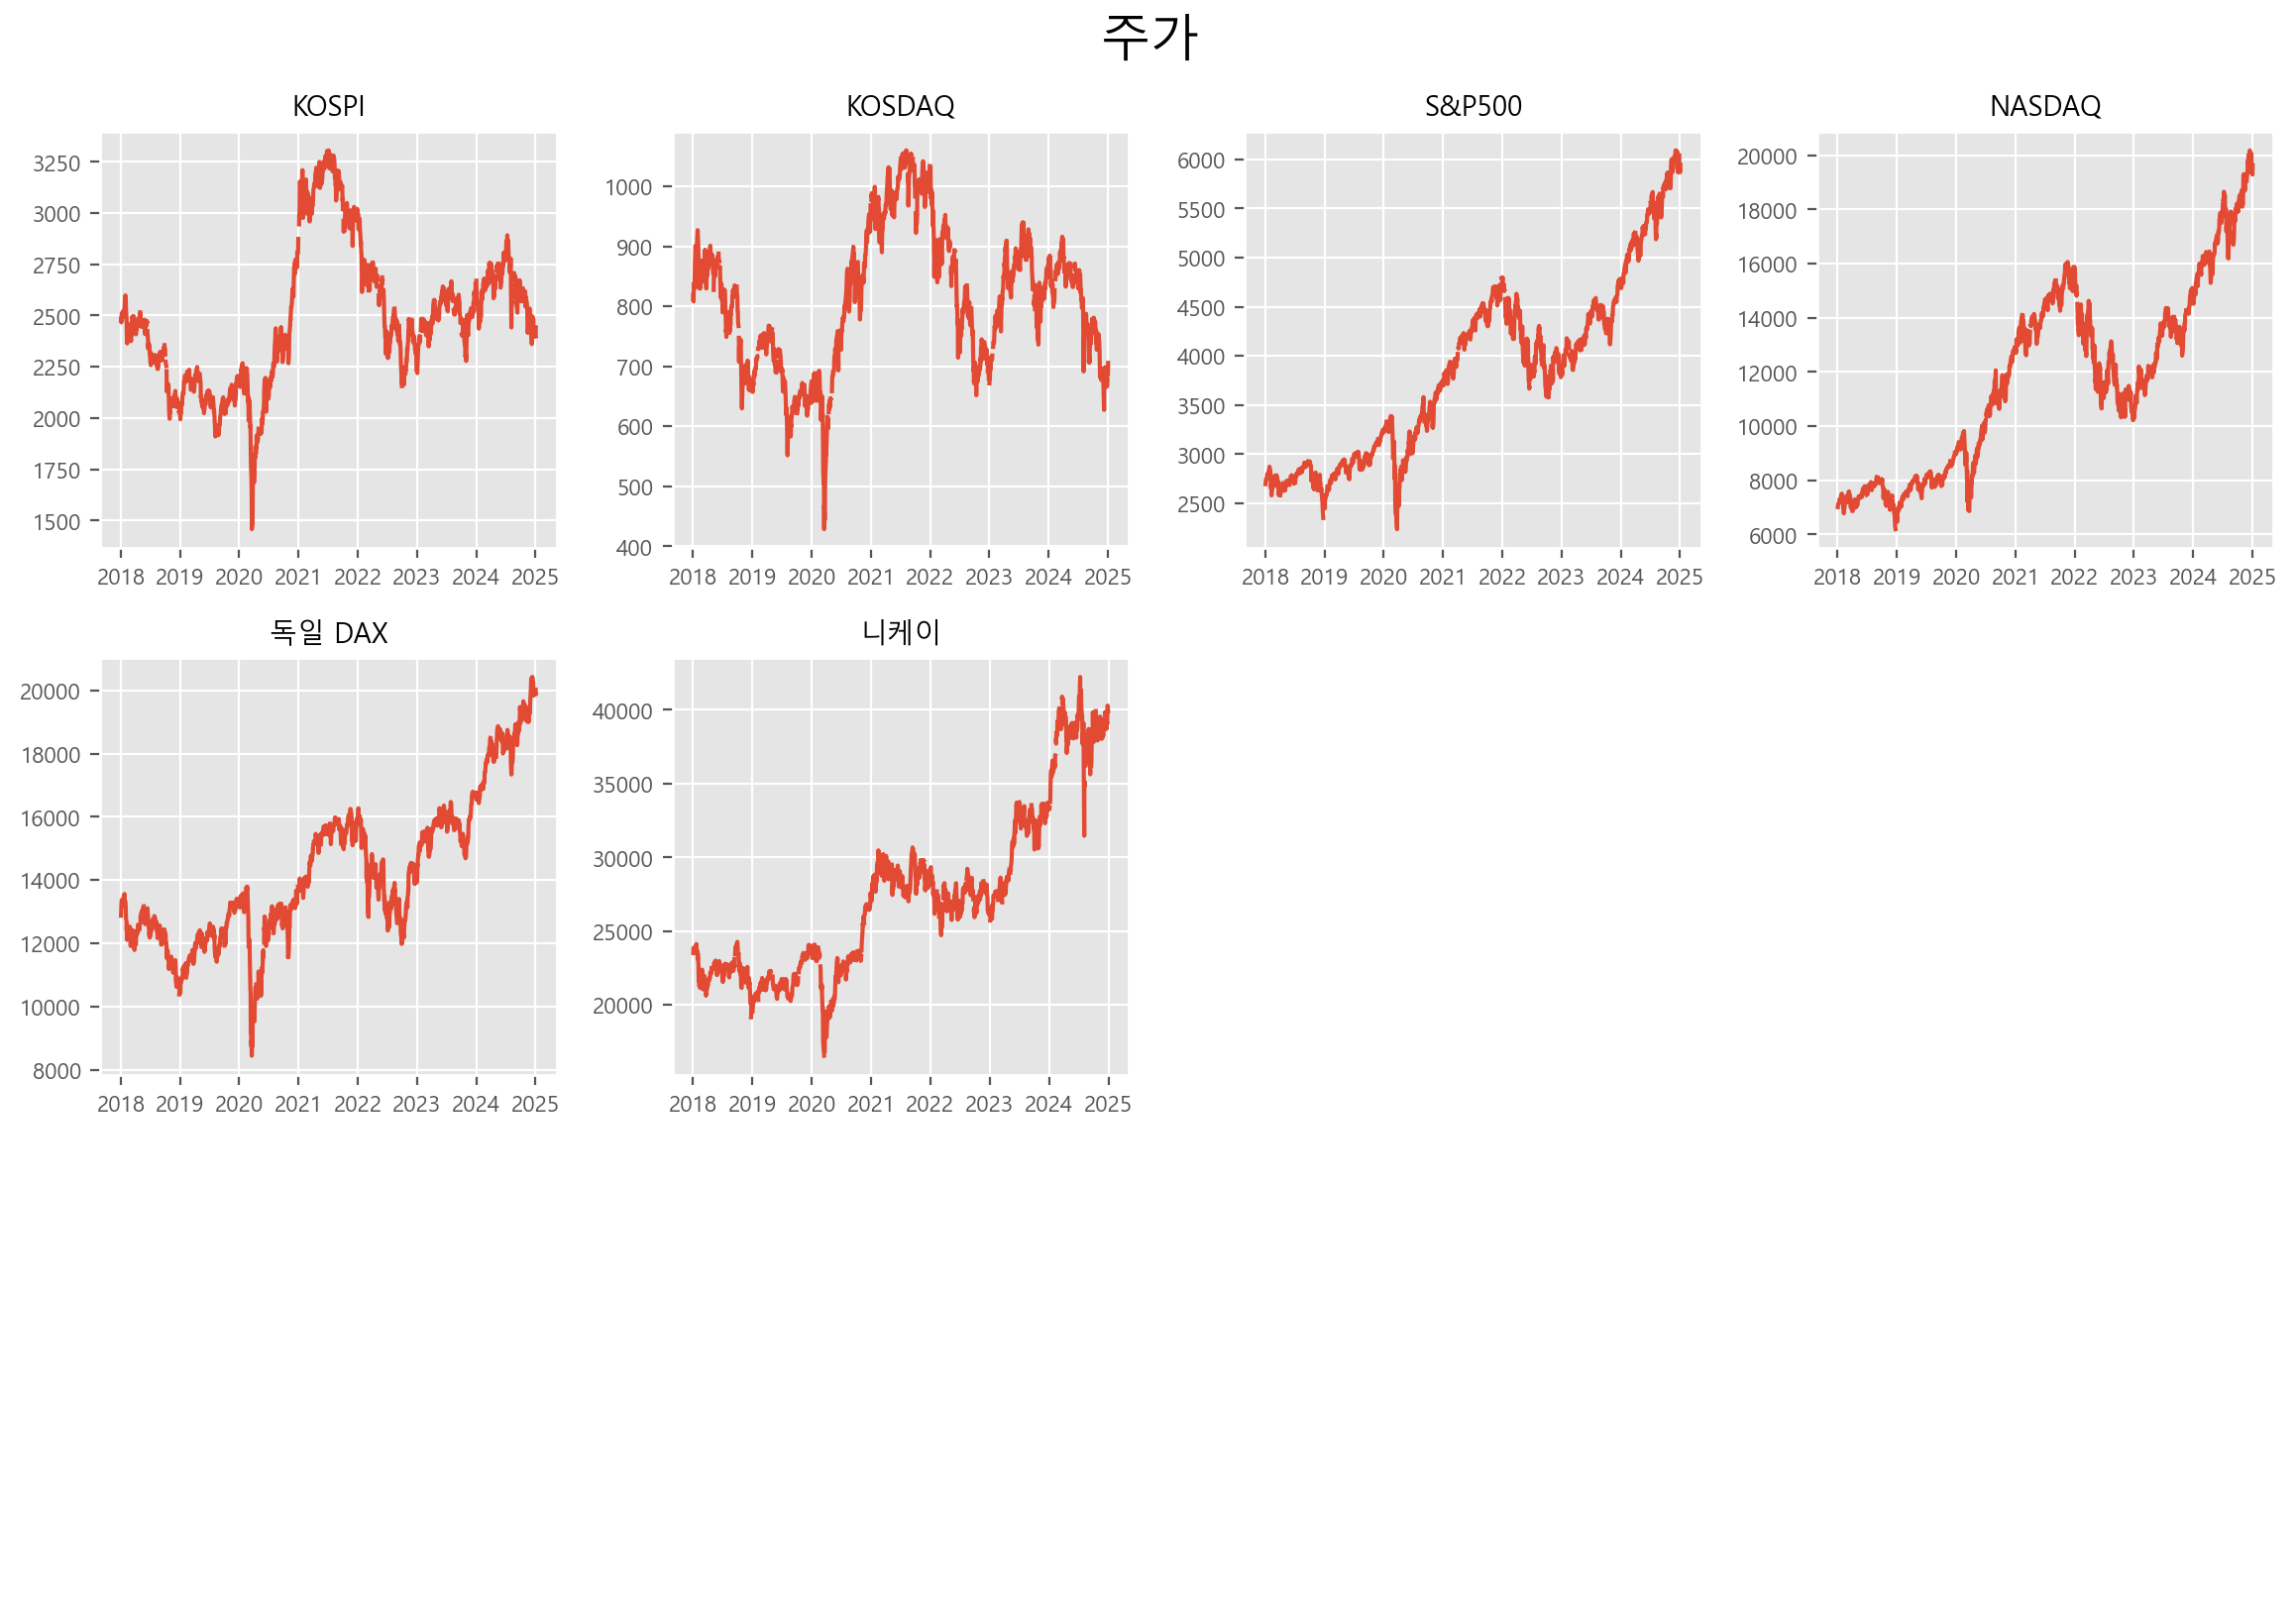

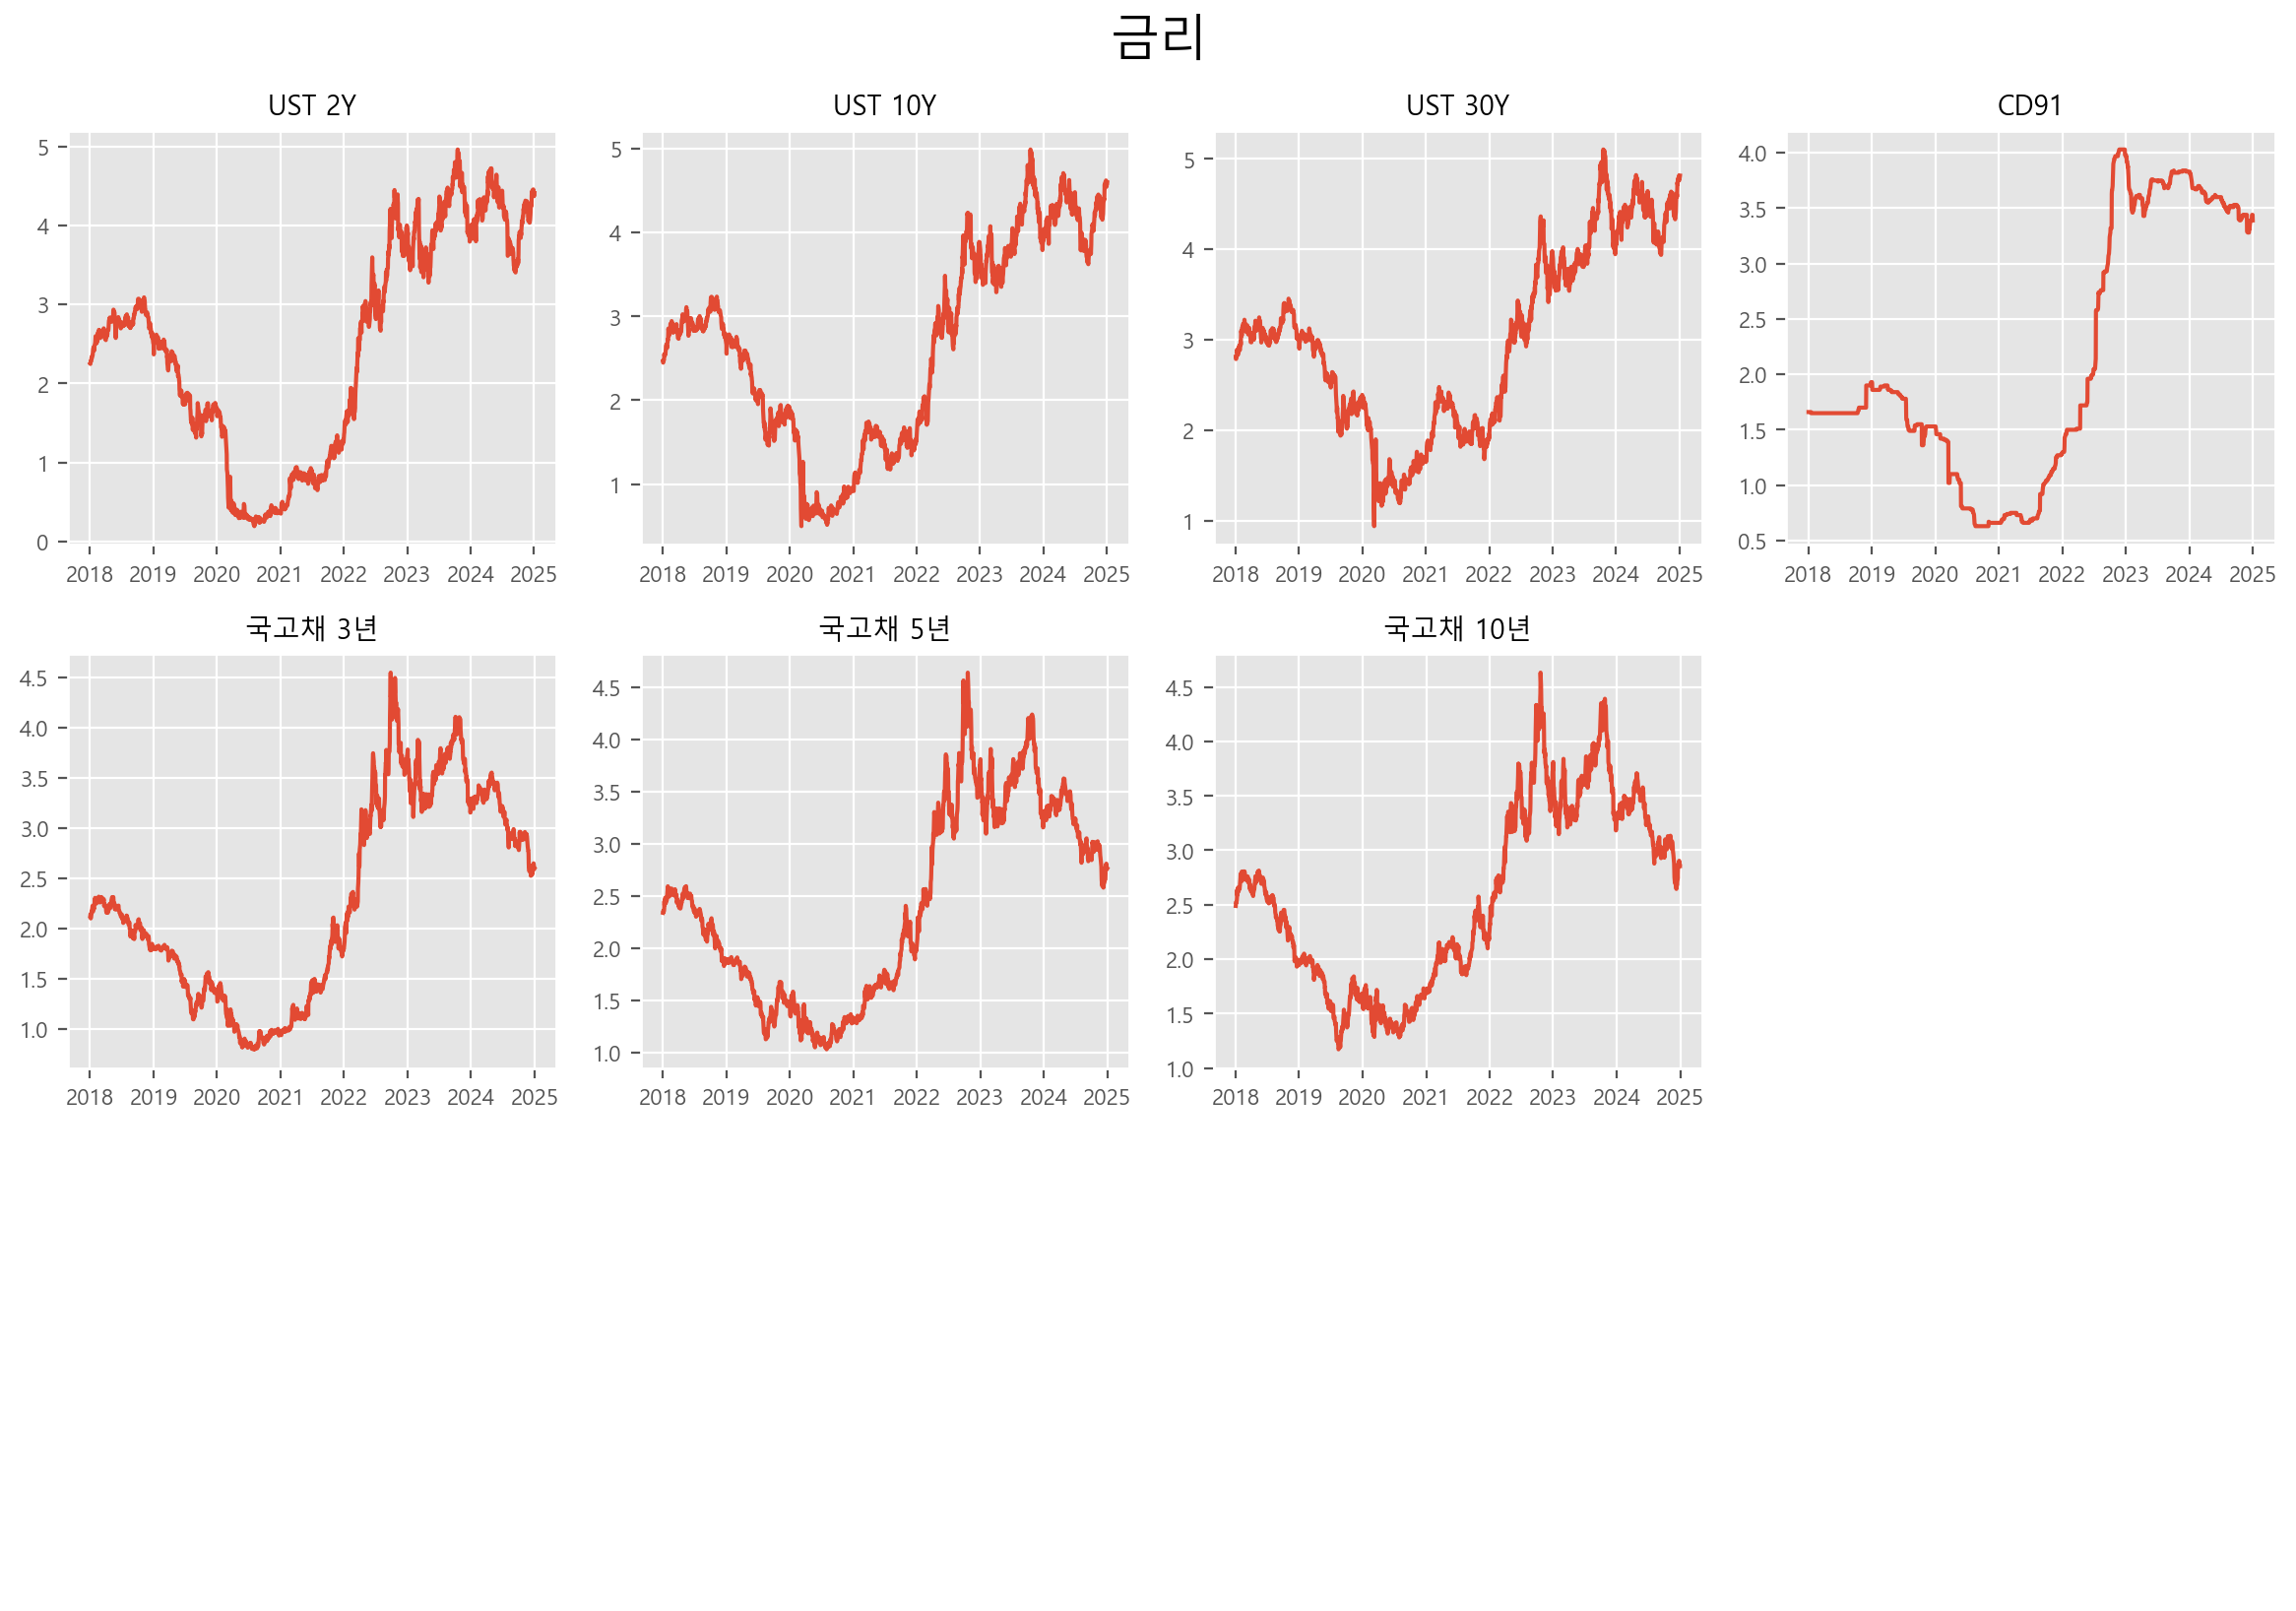

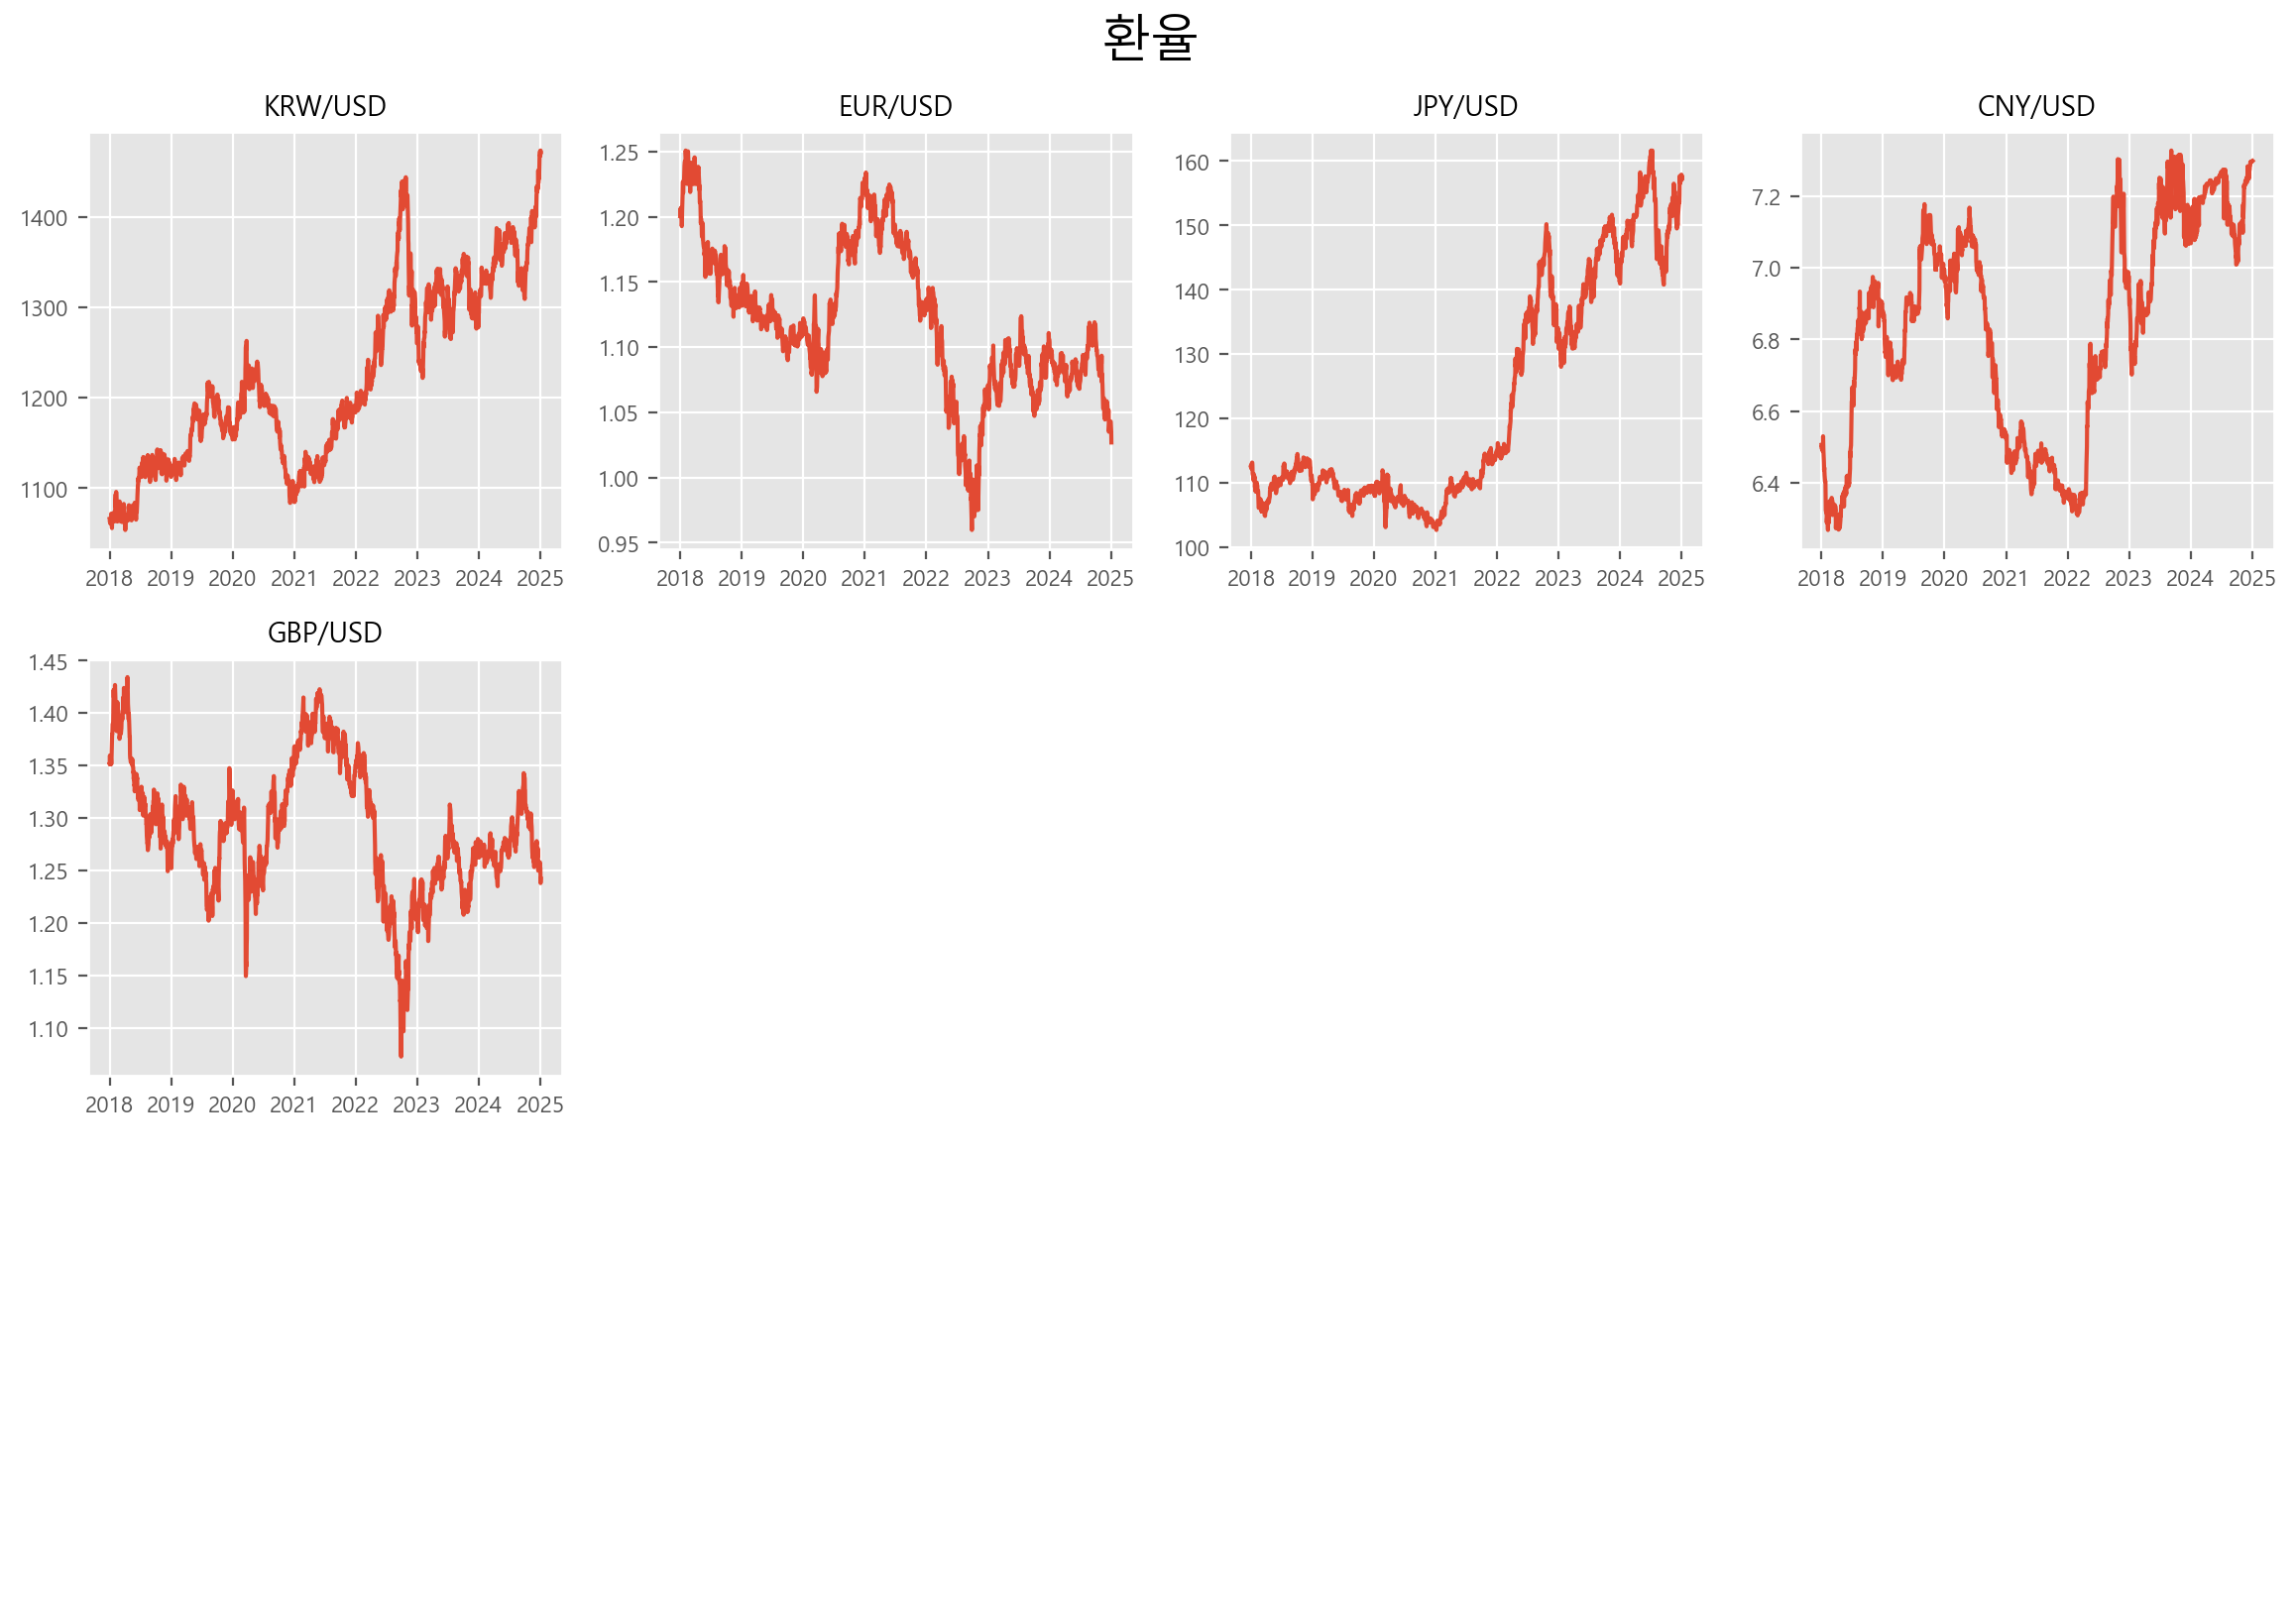

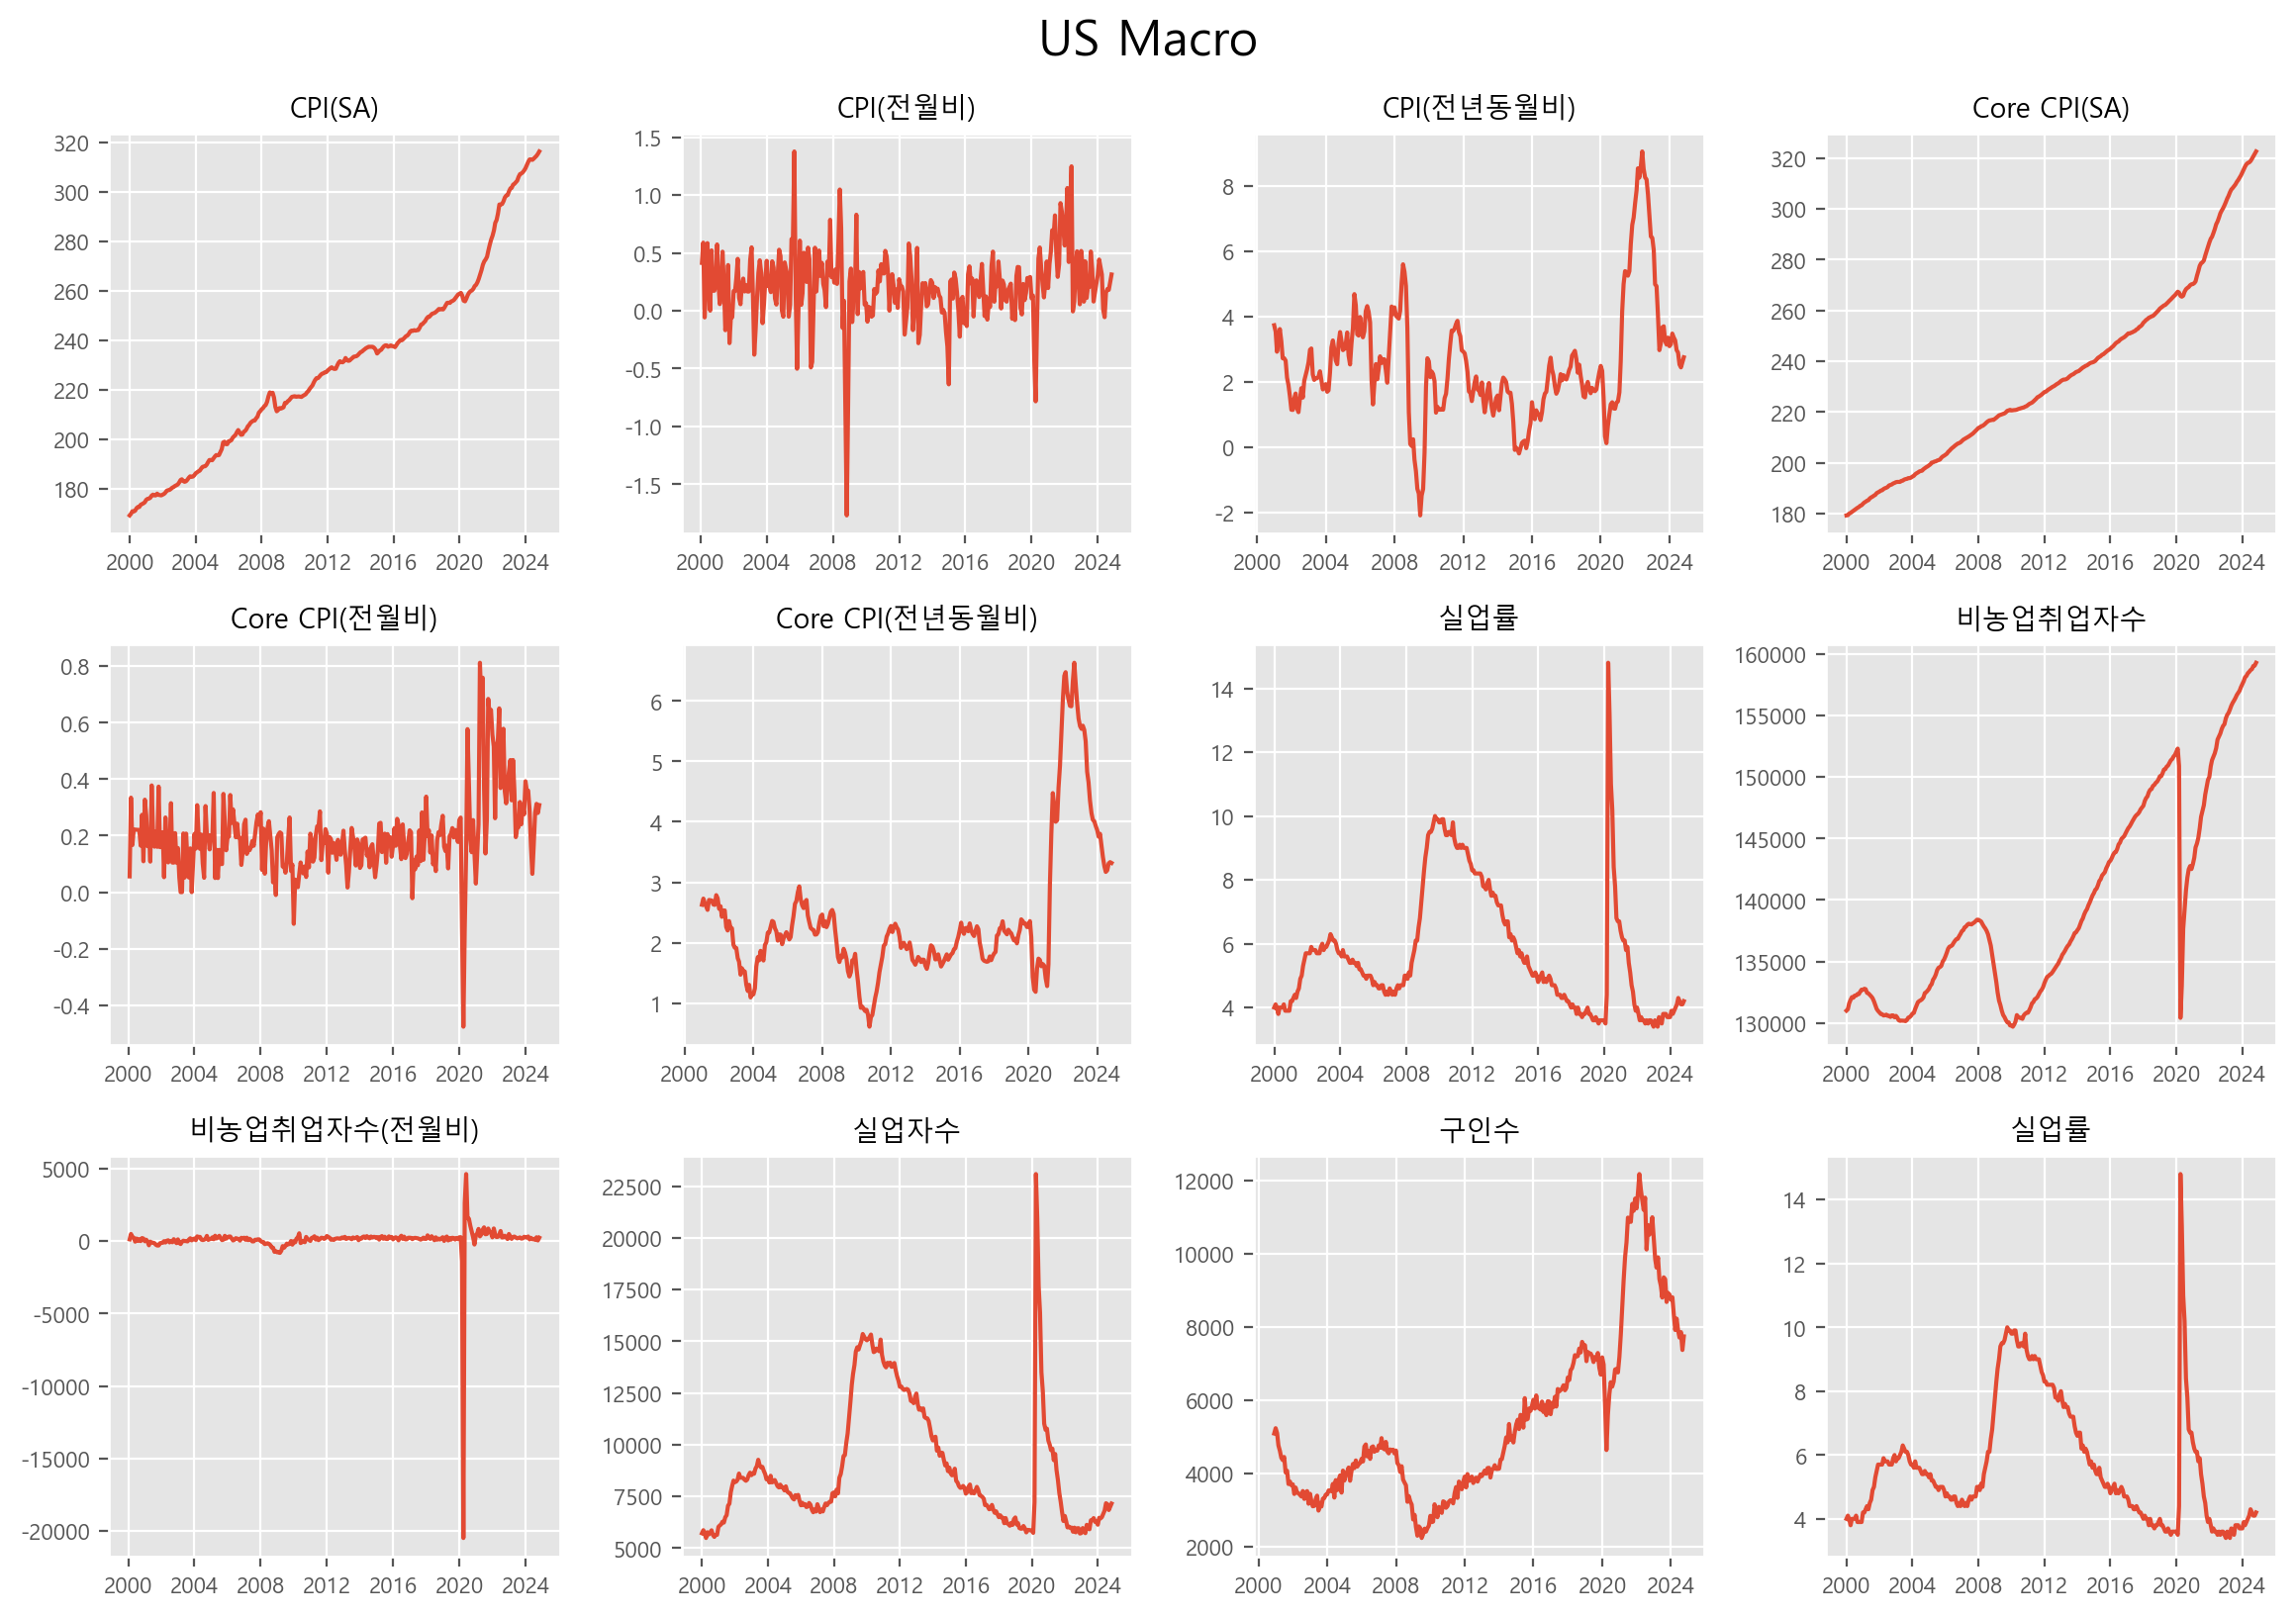

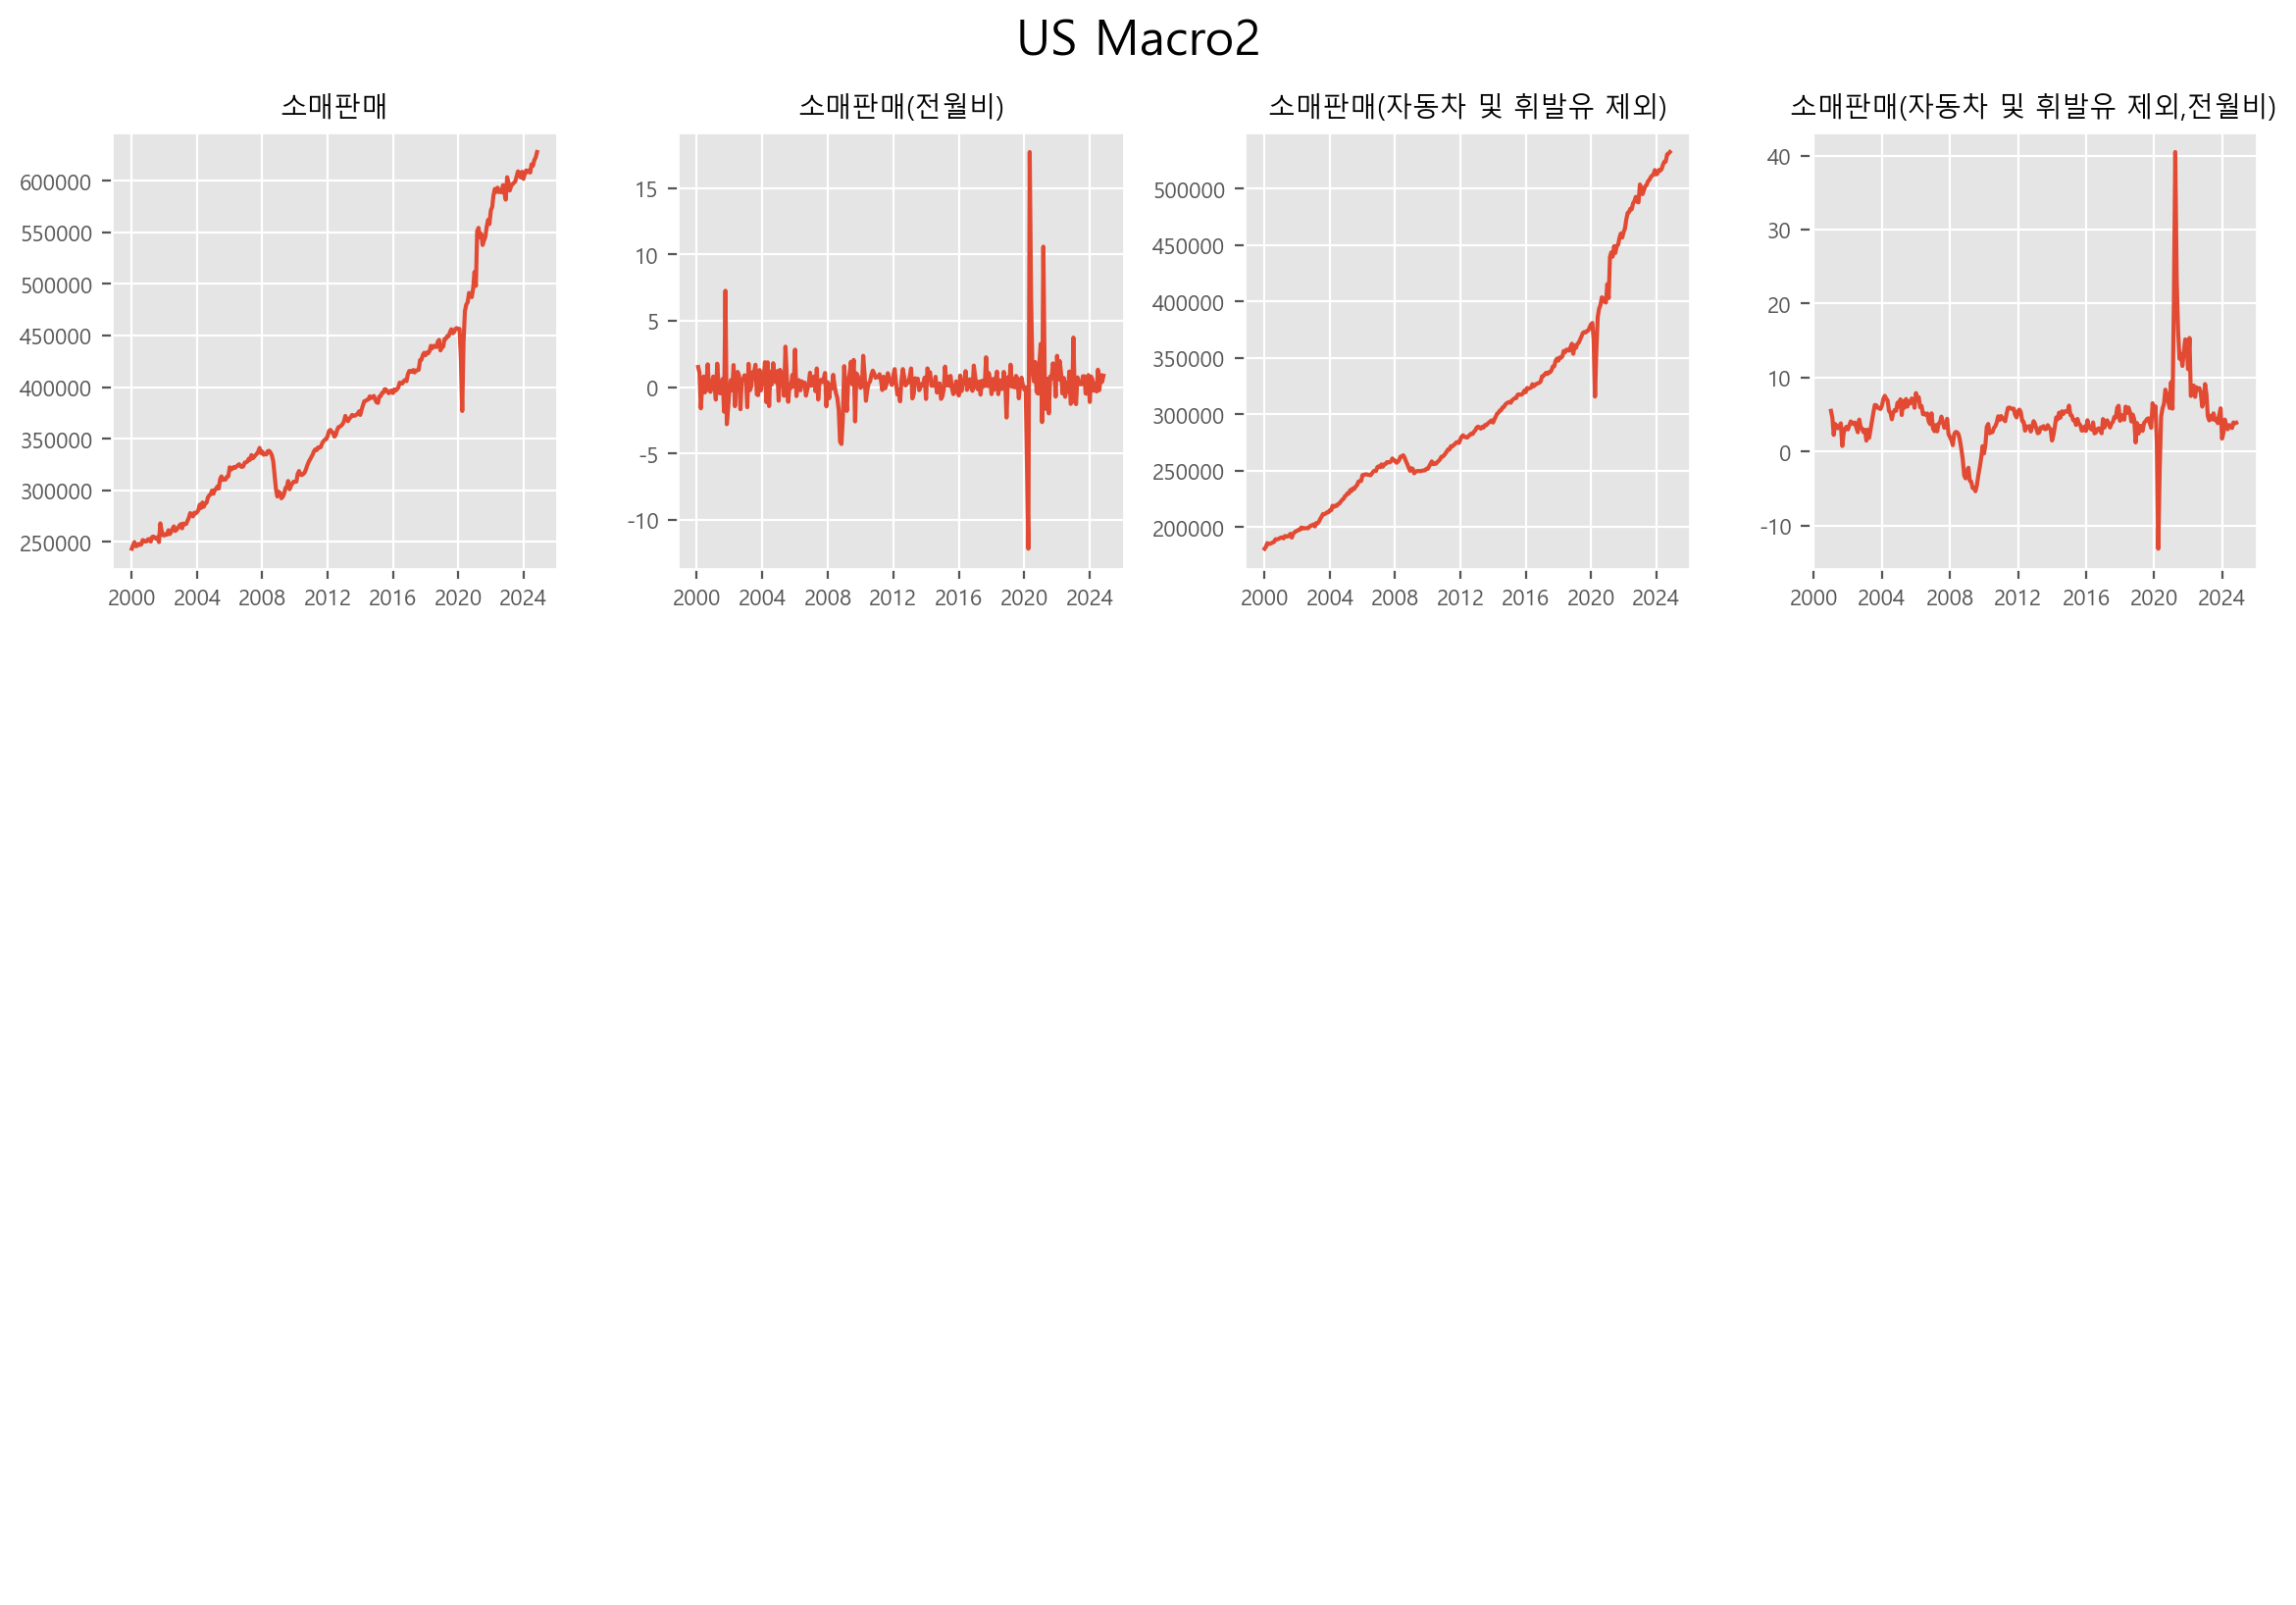

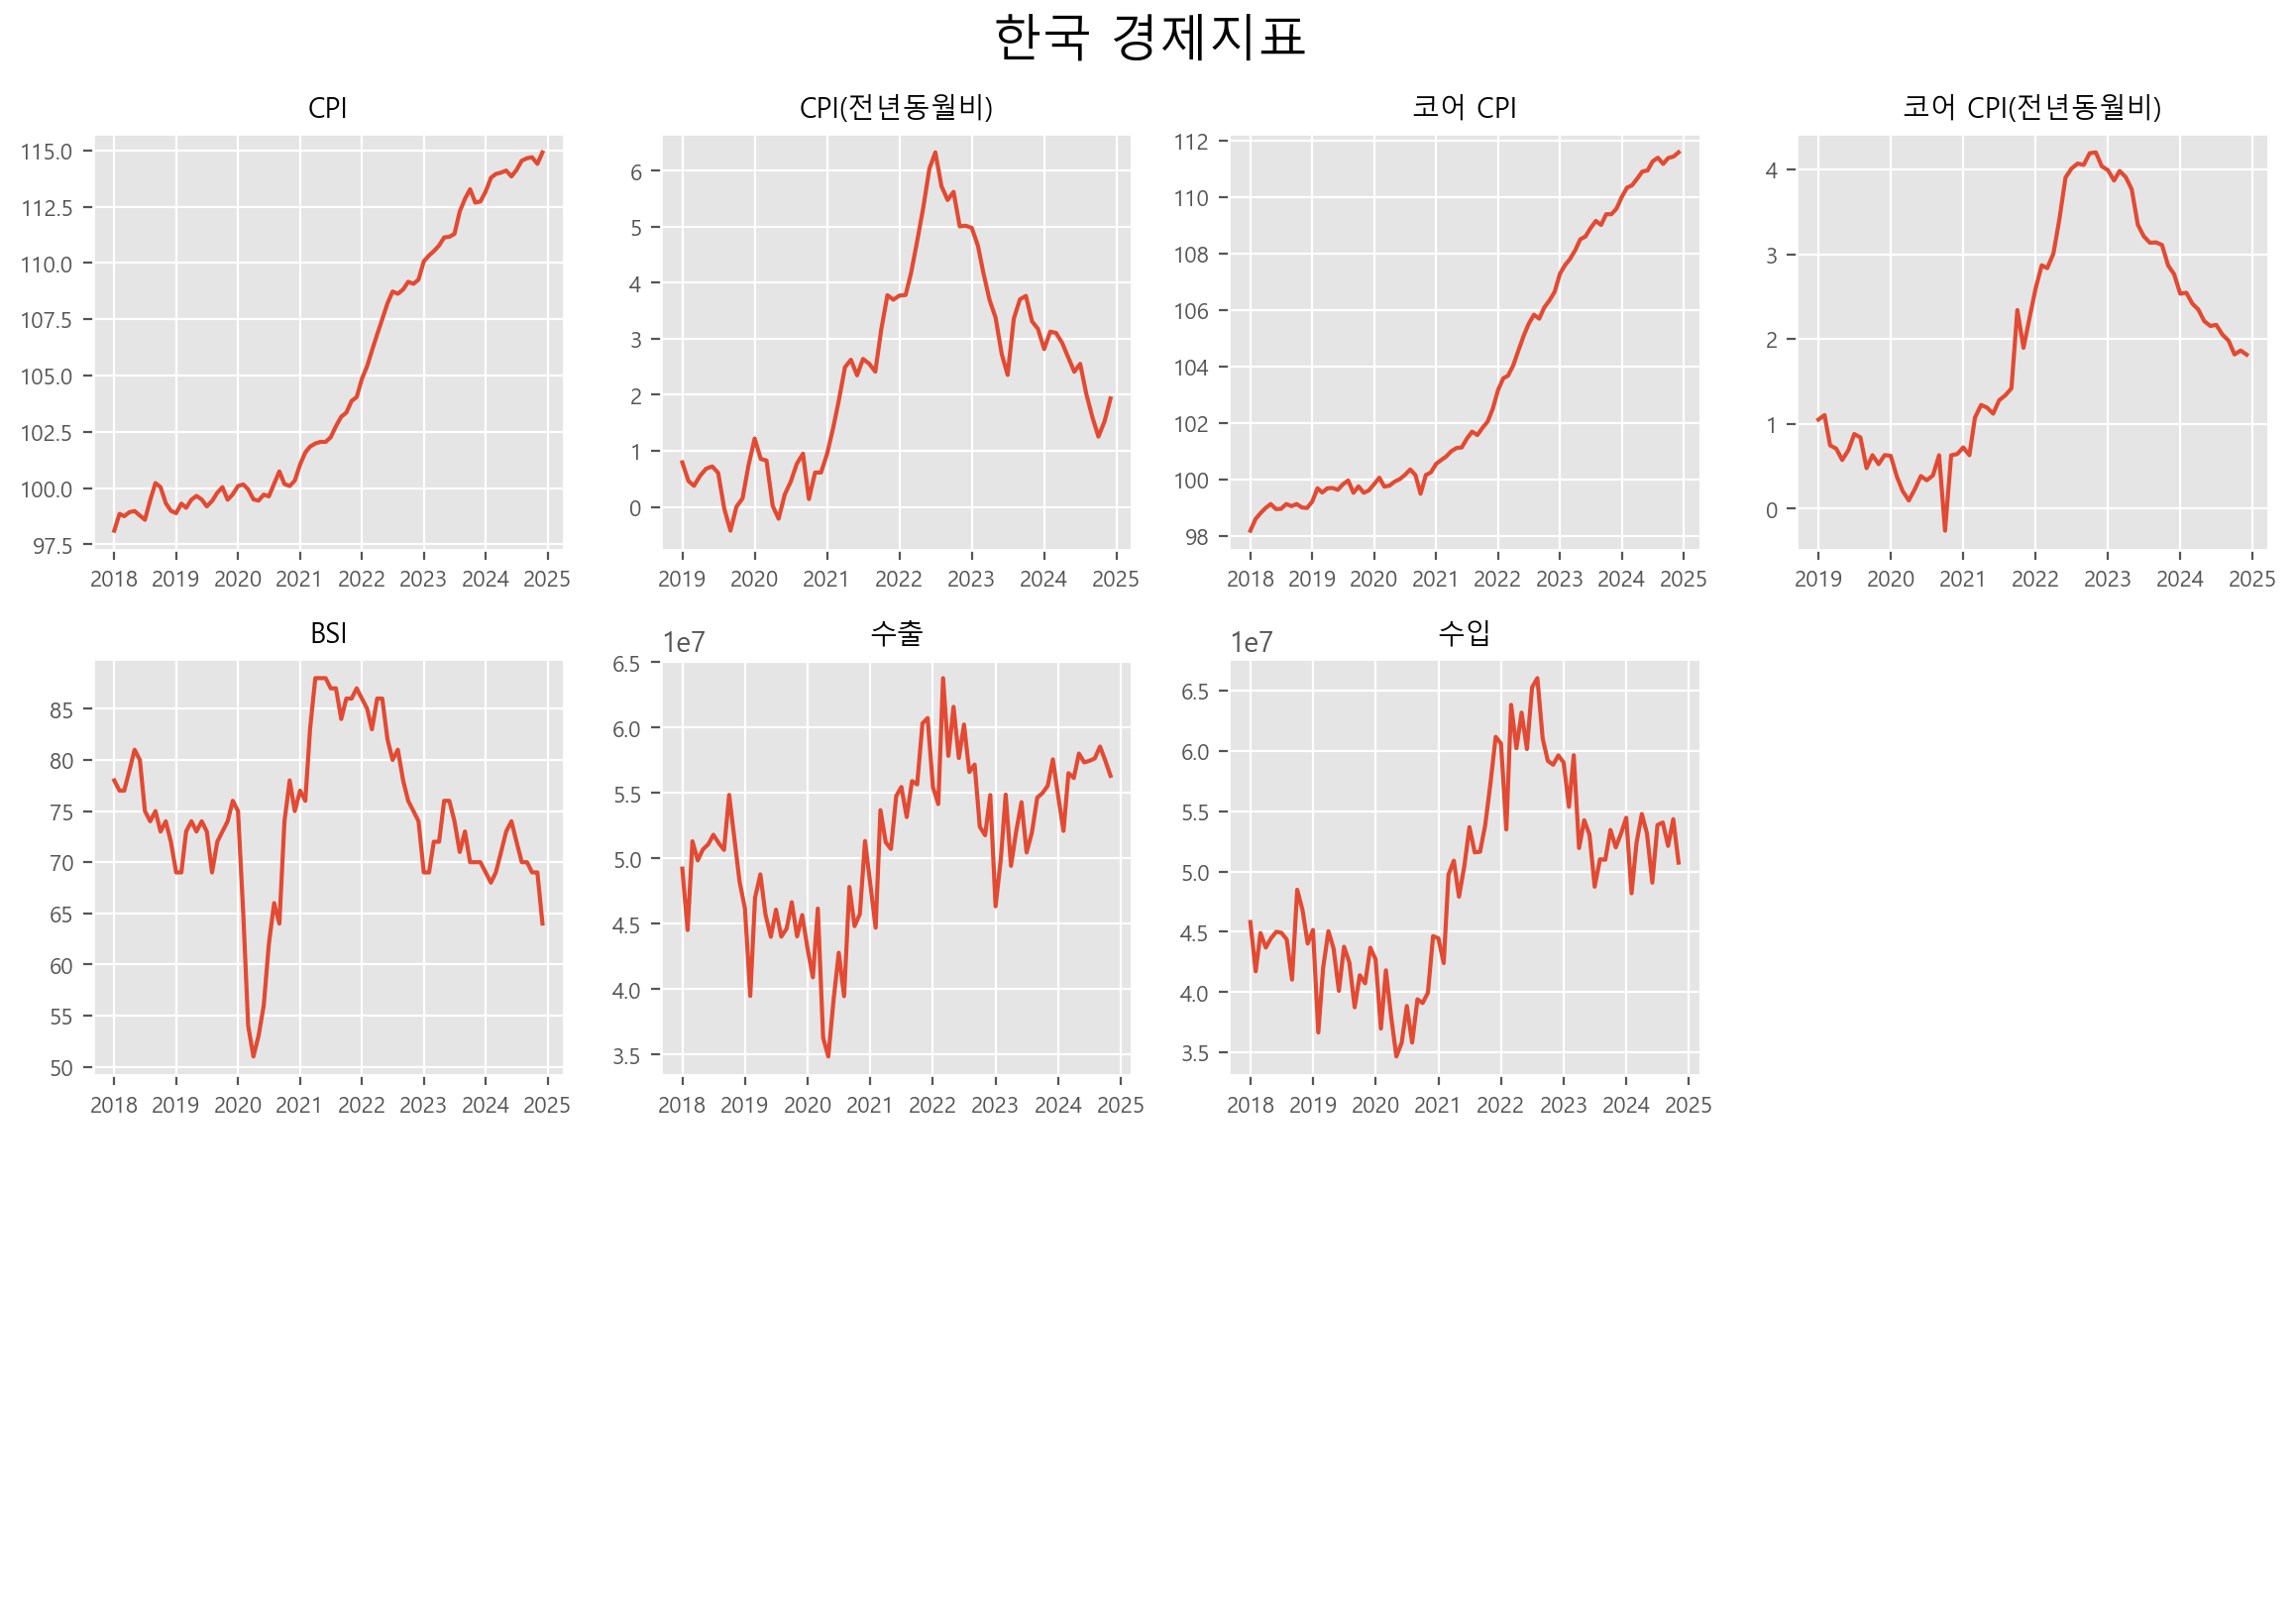

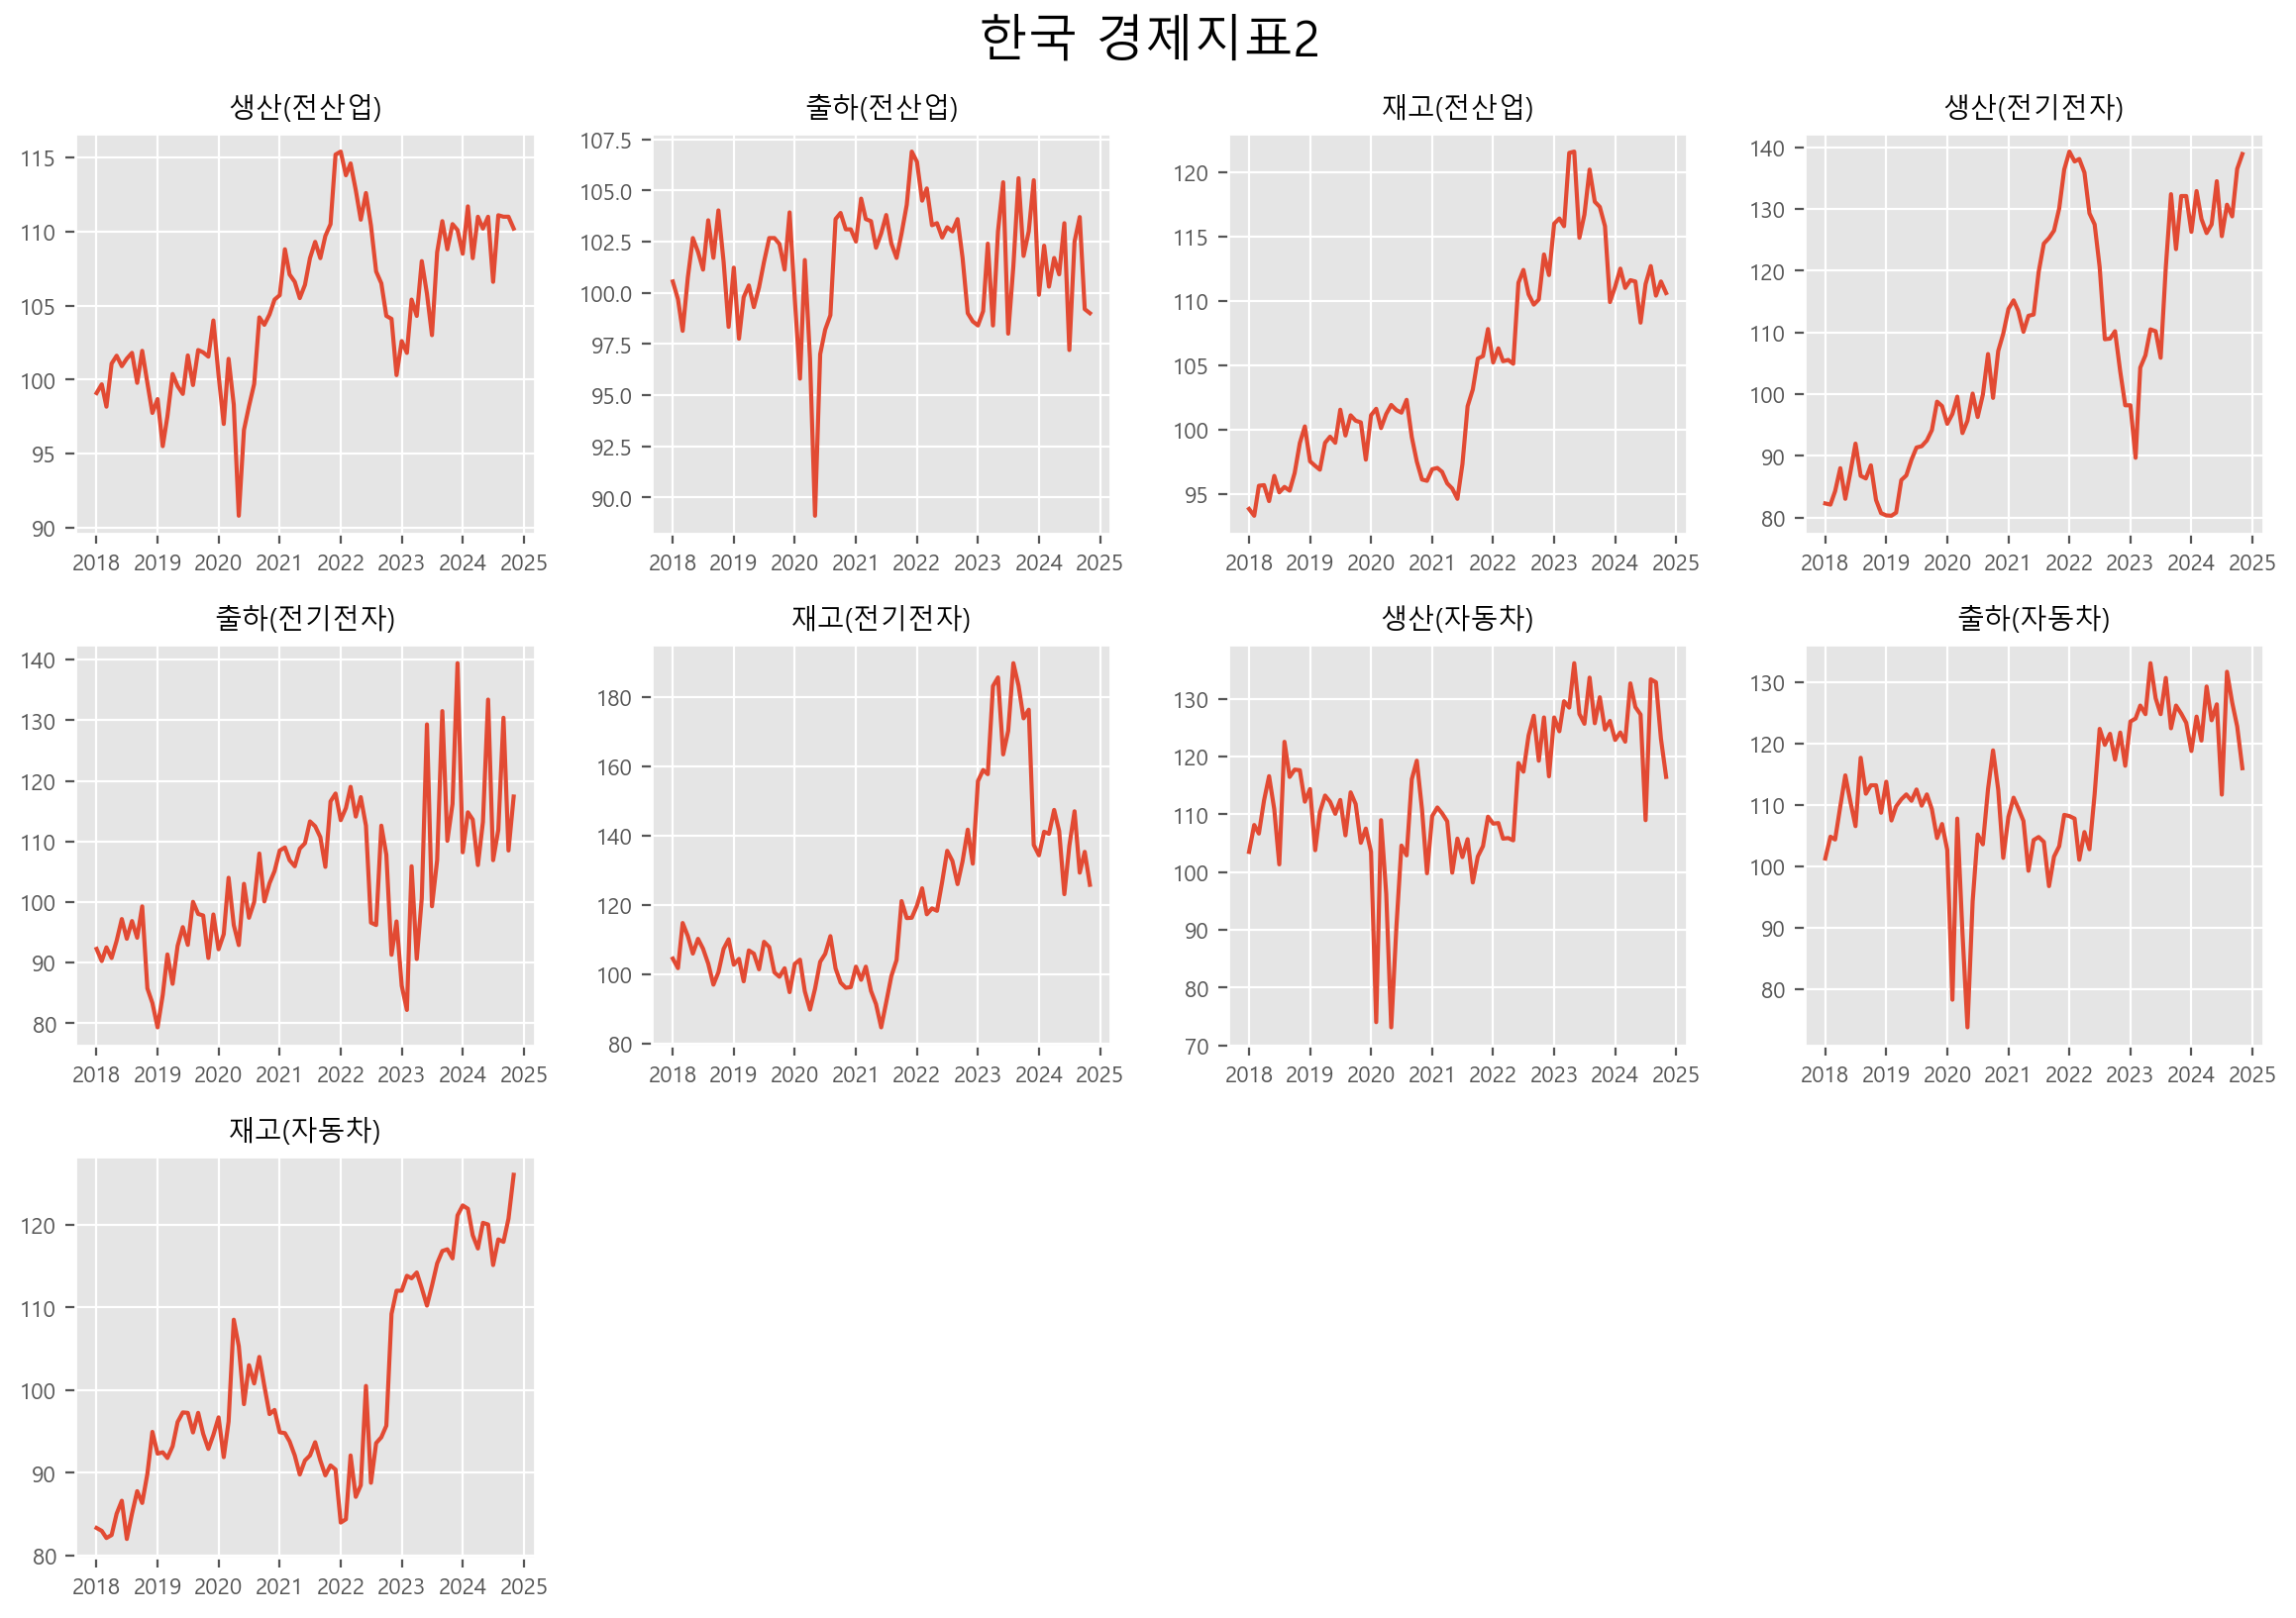

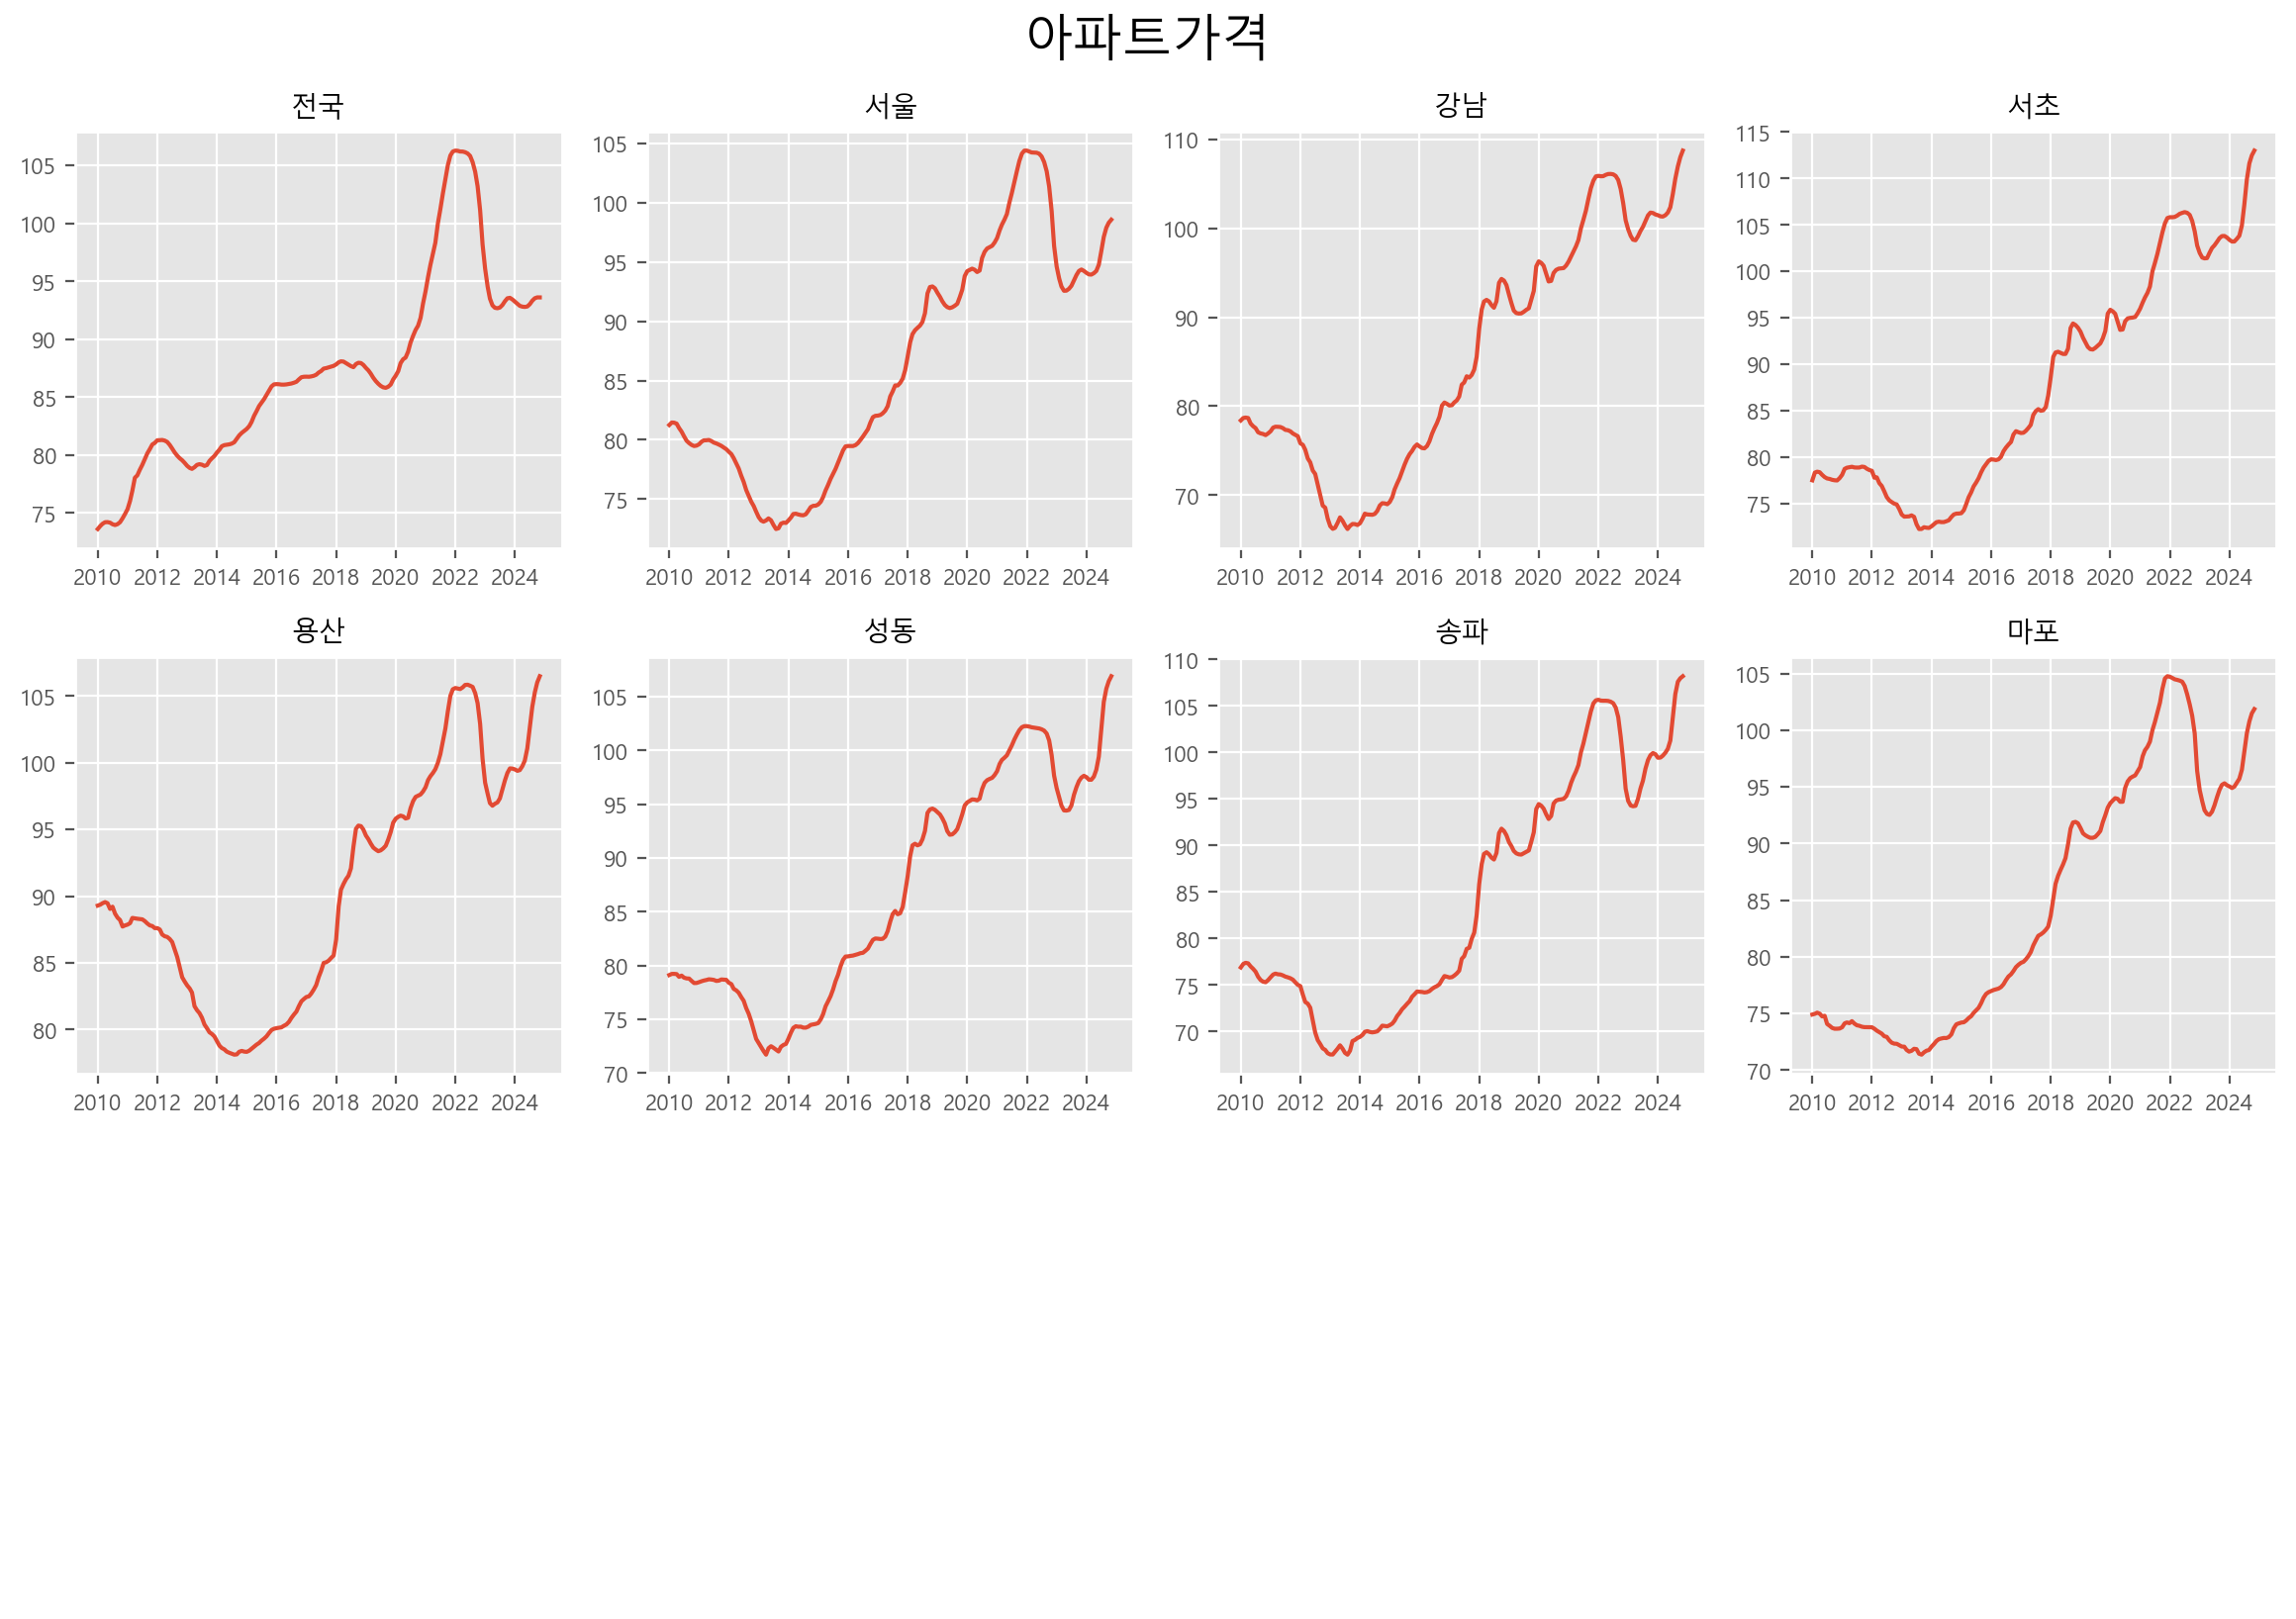

In [53]:
### 대쉬보드 그래프 출력 형태 지정
### ['데이터 범주','그래프제목','데이터프레임','컬럼명'] 순서

dashboards = [['주가','KOSPI','df_stock','^KS11'],
              ['주가','KOSDAQ','df_stock','^KQ11'],
              ['주가','S&P500','df_stock','^GSPC'],
              ['주가','NASDAQ','df_stock','^IXIC'],
              ['주가','독일 DAX','df_stock','^GDAXI'],
              ['주가','니케이','df_stock','^N225'],
              ['금리','UST 2Y','df_rate','^FVX'],
              ['금리','UST 10Y','df_rate','^TNX'],
              ['금리','UST 30Y','df_rate','^TYX'],
              ['금리','CD91','df_rates_d','CD91'],
              ['금리','국고채 3년','df_rates_d','KTB3Y'],
              ['금리','국고채 5년','df_rates_d','KTB5Y'],
              ['금리','국고채 10년','df_rates_d','KTB10Y'],
              ['환율','KRW/USD','df_fx','USDKRW=X'],
              ['환율','EUR/USD','df_fx','EURUSD=X'],
              ['환율','JPY/USD','df_fx','JPY=X'],
              ['환율','CNY/USD','df_fx','CNY=X'],
              ['환율','GBP/USD','df_fx','GBPUSD=X'],
              ['US Macro','CPI(SA)','fred_data','CPI_SA'],
              ['US Macro','CPI(전월비)','fred_data','CPI_MoM'],
              ['US Macro','CPI(전년동월비)','fred_data','CPI_YoY'],
              ['US Macro','Core CPI(SA)','fred_data','CORE_CPI_SA'],
              ['US Macro','Core CPI(전월비)','fred_data','CORE_CPI_MoM'],
              ['US Macro','Core CPI(전년동월비)','fred_data','CORE_CPI_YoY'],
              ['US Macro','실업률','fred_data','UNEMP_RATE'],
              ['US Macro','비농업취업자수','fred_data','PAYEMS'],
              ['US Macro','비농업취업자수(전월비)','fred_data','d_PAYEMS'],
              ['US Macro','실업자수','fred_data','UNEMPLOY'],
              ['US Macro','구인수','fred_data','JOLT_JOB_OPEN'],
              ['US Macro','실업률','fred_data','UNEMP_RATE'],
              ['US Macro2','소매판매','fred_data','RETAIL_SALES'],
              ['US Macro2','소매판매(전월비)','fred_data','RETAIL_MoM'],
              ['US Macro2','소매판매(자동차 및 휘발유 제외)','fred_data','RETAIL_SALES_XAG'],
              ['US Macro2','소매판매(자동차 및 휘발유 제외,전월비)','fred_data','RETAIL_XAG_MoM'],
              ['한국 경제지표','CPI','df_macro_m','KOR_CPI'],
              ['한국 경제지표','CPI(전년동월비)','d_kor_cpi',''],
              ['한국 경제지표','코어 CPI','df_macro_m','KOR_CPI_CORE'],
              ['한국 경제지표','코어 CPI(전년동월비)','d_kor_cpi_core',''],
              ['한국 경제지표','BSI','df_macro_m','KOR_BSI'],
              ['한국 경제지표','수출','df_macro_m','KOR_EXPORT'],
              ['한국 경제지표','수입','df_macro_m','KOR_IMPORT'],
              ['한국 경제지표2','생산(전산업)','df_macro_m','KOR_IP_PROD'],
              ['한국 경제지표2','출하(전산업)','df_macro_m','KOR_IP_SHIP'],
              ['한국 경제지표2','재고(전산업)','df_macro_m','KOR_IP_INV'],
              ['한국 경제지표2','생산(전기전자)','df_macro_m','KOR_IP_ELEC_PROD'],
              ['한국 경제지표2','출하(전기전자)','df_macro_m','KOR_IP_ELEC_SHIP'],
              ['한국 경제지표2','재고(전기전자)','df_macro_m','KOR_IP_ELEC_INV'],
              ['한국 경제지표2','생산(자동차)','df_macro_m','KOR_IP_CAR_PROD'],
              ['한국 경제지표2','출하(자동차)','df_macro_m','KOR_IP_CAR_SHIP'],
              ['한국 경제지표2','재고(자동차)','df_macro_m','KOR_IP_CAR_INV'],
              ['아파트가격','전국','apt_pr','유형별 매매가격지수_아파트_전국'],
              ['아파트가격','서울','apt_pr','유형별 매매가격지수_아파트_서울'],
              ['아파트가격','강남','apt_pr','유형별 매매가격지수_아파트_강남'],
              ['아파트가격','서초','apt_pr','유형별 매매가격지수_아파트_서초'],
              ['아파트가격','용산','apt_pr','유형별 매매가격지수_아파트_용산'],
              ['아파트가격','성동','apt_pr','유형별 매매가격지수_아파트_성동'],
              ['아파트가격','송파','apt_pr','유형별 매매가격지수_아파트_송파'],
              ['아파트가격','마포','apt_pr','유형별 매매가격지수_아파트_마포']
              ]


df_gr_out = pd.DataFrame(dashboards,columns = ['cat','name','df','ticker'])
dashboard(df_gr_out)

In [ ]:
### Dashboard 작성 연습






# 수고하셨습니다!!!